<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/main/Buy%26Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
# Implement Buy&Hold strategy
def buy_and_sell(df, InitialCapital):
    '''
    Update capital and number of shares after each buy or sell based on labels.

    Parameters
    ----------
        df : dataframe
            target dataframe for using buh&hold strategy
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after implementing buy&hold strategy on input dataframe
    """
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        
        if new_trend == 1 and capital != 0 and df.index[i] <= last_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif new_trend != old_trend and new_trend == 0:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [3]:
# Calculate rate of return
def ROR(df, InitialCapital):
    '''
    Calculate rate of return for each row that we have stock

    Parameters
    ----------
        df : dataframe
            dataframe for calculating ror
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after updating ROR values
    """
    '''

    df = df.assign(ROR=pd.Series(df.FinalCapital - InitialCapital)/ InitialCapital * 100)

    return df

In [4]:
# def DD(df):
#     pct = df[["Price"]].pct_change()
#     wealth_index = InitialCapital * (1 + pct["Price"]).cumprod()
#     previous_peaks = wealth_index.cummax()
#     drawdown = (wealth_index - previous_peaks) / previous_peaks
#     drawdown = list(abs(drawdown))
#     drawdown[0] = 0
#     df = df.assign(DD=pd.Series(drawdown))
#     return df

def DD(df):
    max_ror = max(df.ROR)
    DD_list = []
    for ror in df.ROR:
        DD_list.append(max_ror - ror)
    df = df.assign(DD=pd.Series(DD_list))
    return df

In [5]:
# Sharpe Ratio
# This should be changed
def sharpe_ratio(df):
    R = df.ROR[-1:].values[0]
    sr = R / df.ROR.std()
    return sr

In [6]:
def metrics(df, InitialCapital):
    df = buy_and_sell(df, InitialCapital)
    df = ROR(df, InitialCapital)
    df = DD(df)
    MDD = max(abs(df.DD))
    # Add RRR column
    df['RRR'] = (df['ROR'] / MDD) * 100

    sr = sharpe_ratio(df)
    print(f"Sharpe Ratio = {sr} \n")
    print(f"MDD = {MDD} \n")
    return df

In [7]:
InitialCapital = 10e6
InitialCapital

10000000.0

In [8]:
# This function will be uncomment after updating the main code

# def add_metrics(df, file_name):
#     metrics_ = metrics(df, InitialCapital)
#     file_name = file_name + '_metrics.csv'
#     metrics_.to_csv(file_name)
#     print(metrics_.tail())

def add_metrics(df, file_name, dataset_type = 'china'):
    date_col = 'DATE'
    close_col = 'closingprice'
    if dataset_type == 'crypto':
        date_col = 'Date'
        close_col = 'Price'
    elif dataset_type == 'sp':
        date_col = '<DATE>'
        close_col = '<CLOSE>'
    data = {'Date': df[date_col], 'Price': df[close_col],
        'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
    df_new = pd.DataFrame(data)
    
    metrics_ = metrics(df_new, InitialCapital)
    file_name_1 = file_name + '_metrics.csv'
    metrics_.to_csv(file_name_1)
    metrics_ = metrics_[metrics_['Number of Shares'] != '0'] 
    file_name_2 = file_name + '_metrics_filtered.csv'
    metrics_.to_csv(file_name_2)
    return metrics_

In [9]:
# This function will be added to the main code

# def modify_df(df, dataset_type):
#     date_col = 'DATE'
#     close_col = 'closingprice'
#     if dataset_type == 'crypto':
#         date_col = 'Date'
#         close_col = 'Price'
#     data = {'Date': df[date_col], 'Price': df[close_col],
#         'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
#     df_new = pd.DataFrame(data)
#     return df_new

# BTC

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('btc_lstm.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm', dataset_type='crypto')

Sharpe Ratio = 1.2083079648278074 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  10.163207  0.060956  1906.962315
286  Oct 13, 2020  11423.8      0  ...  10.163207  0.069920  1906.962315
287  Oct 14, 2020  11420.4      0  ...  10.163207  0.070197  1906.962315
288  Oct 15, 2020  11503.0      0  ...  10.163207  0.063472  1906.962315
289  Oct 16, 2020  11322.0      1  ...  10.163207  0.078208  1906.962315

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.101632e+07,10.163207,0.060956,1906.962315
286,"Oct 13, 2020",11423.8,0,,0,1.101632e+07,10.163207,0.069920,1906.962315
287,"Oct 14, 2020",11420.4,0,,0,1.101632e+07,10.163207,0.070197,1906.962315
288,"Oct 15, 2020",11503.0,0,,0,1.101632e+07,10.163207,0.063472,1906.962315


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_p', dataset_type='crypto')

Sharpe Ratio = 0.3025624073108589 

MDD = 0.5329526758927707 

             Date    Price  Label  ...      ROR        DD         RRR
285  Oct 12, 2020  11533.9      0  ...  2.65455  0.060956  498.083554
286  Oct 13, 2020  11423.8      0  ...  2.65455  0.069920  498.083554
287  Oct 14, 2020  11420.4      0  ...  2.65455  0.070197  498.083554
288  Oct 15, 2020  11503.0      0  ...  2.65455  0.063472  498.083554
289  Oct 16, 2020  11322.0      1  ...  2.65455  0.078208  498.083554

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.026545e+07,2.654550,0.060956,498.083554
286,"Oct 13, 2020",11423.8,0,,0,1.026545e+07,2.654550,0.069920,498.083554
287,"Oct 14, 2020",11420.4,0,,0,1.026545e+07,2.654550,0.070197,498.083554
288,"Oct 15, 2020",11503.0,0,,0,1.026545e+07,2.654550,0.063472,498.083554


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 1.8991965111347162 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  23.986295  0.060956  4500.642535
286  Oct 13, 2020  11423.8      0  ...  23.986295  0.069920  4500.642535
287  Oct 14, 2020  11420.4      1  ...  23.986295  0.070197  4500.642535
288  Oct 15, 2020  11503.0      0  ...  24.883047  0.063472  4668.903652
289  Oct 16, 2020  11322.0      1  ...  24.883047  0.078208  4668.903652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.239863e+07,23.986295,0.060956,4500.642535
286,"Oct 13, 2020",11423.8,0,,0,1.239863e+07,23.986295,0.069920,4500.642535
287,"Oct 14, 2020",11420.4,1,Buy,1085.66,1.239863e+07,23.986295,0.070197,4500.642535
288,"Oct 15, 2020",11503.0,0,Sell,0,1.248830e+07,24.883047,0.063472,4668.903652


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.6920681131595754 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -23.797416  0.060956 -4465.202545
286  Oct 13, 2020  11423.8      0  ... -23.797416  0.069920 -4465.202545
287  Oct 14, 2020  11420.4      0  ... -23.797416  0.070197 -4465.202545
288  Oct 15, 2020  11503.0      0  ... -23.797416  0.063472 -4465.202545
289  Oct 16, 2020  11322.0      1  ... -23.797416  0.078208 -4465.202545

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,0,Sell,0,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.620258e+06,-23.797416,0.060956,-4465.202545
286,"Oct 13, 2020",11423.8,0,,0,7.620258e+06,-23.797416,0.069920,-4465.202545
287,"Oct 14, 2020",11420.4,0,,0,7.620258e+06,-23.797416,0.070197,-4465.202545
288,"Oct 15, 2020",11503.0,0,,0,7.620258e+06,-23.797416,0.063472,-4465.202545


## GRU

In [ ]:
# Cross
df = pd.read_csv('btc_gru.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru', dataset_type='crypto')

Sharpe Ratio = 1.2393004569352466 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.164535  0.060956  2282.479321
286  Oct 13, 2020  11423.8      0  ...  12.164535  0.069920  2282.479321
287  Oct 14, 2020  11420.4      0  ...  12.164535  0.070197  2282.479321
288  Oct 15, 2020  11503.0      1  ...  12.164535  0.063472  2282.479321
289  Oct 16, 2020  11322.0      1  ...  12.164535  0.078208  2282.479321

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121645e+07,12.164535,0.060956,2282.479321
286,"Oct 13, 2020",11423.8,0,,0,1.121645e+07,12.164535,0.069920,2282.479321
287,"Oct 14, 2020",11420.4,0,,0,1.121645e+07,12.164535,0.070197,2282.479321
288,"Oct 15, 2020",11503.0,1,,0,1.121645e+07,12.164535,0.063472,2282.479321


In [ ]:
# Purge
df = pd.read_csv('btc_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_p', dataset_type='crypto')

Sharpe Ratio = -1.663998456368676 

MDD = 0.5329526758927707 

             Date    Price  Label  ...       ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -45.70201  0.060956 -8575.247256
286  Oct 13, 2020  11423.8      0  ... -45.70201  0.069920 -8575.247256
287  Oct 14, 2020  11420.4      0  ... -45.70201  0.070197 -8575.247256
288  Oct 15, 2020  11503.0      1  ... -45.70201  0.063472 -8575.247256
289  Oct 16, 2020  11322.0      1  ... -45.70201  0.078208 -8575.247256

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.429799e+06,-45.702010,0.060956,-8575.247256
286,"Oct 13, 2020",11423.8,0,,0,5.429799e+06,-45.702010,0.069920,-8575.247256
287,"Oct 14, 2020",11420.4,0,,0,5.429799e+06,-45.702010,0.070197,-8575.247256
288,"Oct 15, 2020",11503.0,1,,0,5.429799e+06,-45.702010,0.063472,-8575.247256


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('btc_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.1479002748718312 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.145533  0.060956  2278.913945
286  Oct 13, 2020  11423.8      0  ...  12.145533  0.069920  2278.913945
287  Oct 14, 2020  11420.4      0  ...  12.145533  0.070197  2278.913945
288  Oct 15, 2020  11503.0      1  ...  12.145533  0.063472  2278.913945
289  Oct 16, 2020  11322.0      1  ...  12.145533  0.078208  2278.913945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121455e+07,12.145533,0.060956,2278.913945
286,"Oct 13, 2020",11423.8,0,,0,1.121455e+07,12.145533,0.069920,2278.913945
287,"Oct 14, 2020",11420.4,0,,0,1.121455e+07,12.145533,0.070197,2278.913945
288,"Oct 15, 2020",11503.0,1,,0,1.121455e+07,12.145533,0.063472,2278.913945


In [ ]:
# Purge
df = pd.read_csv('btc_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.7336241468858022 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -43.896829  0.060956 -8236.534069
286  Oct 13, 2020  11423.8      0  ... -43.896829  0.069920 -8236.534069
287  Oct 14, 2020  11420.4      0  ... -43.896829  0.070197 -8236.534069
288  Oct 15, 2020  11503.0      1  ... -43.896829  0.063472 -8236.534069
289  Oct 16, 2020  11322.0      1  ... -43.896829  0.078208 -8236.534069

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.610317e+06,-43.896829,0.060956,-8236.534069
286,"Oct 13, 2020",11423.8,0,,0,5.610317e+06,-43.896829,0.069920,-8236.534069
287,"Oct 14, 2020",11420.4,0,,0,5.610317e+06,-43.896829,0.070197,-8236.534069
288,"Oct 15, 2020",11503.0,1,,0,5.610317e+06,-43.896829,0.063472,-8236.534069


## SVM

In [ ]:
# Cross
df = pd.read_csv('btc_svm.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## LR

In [ ]:
# Cross
df = pd.read_csv('btc_logreg.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('btc_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


# ETH

## LSTM

In [ ]:
# Cross
df = pd.read_csv('eth_lstm.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm', dataset_type='crypto')

Sharpe Ratio = 2.665214345466587 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD          RRR
285  Oct 12, 2020  386.68      1  ...  136.115906  0.187306  21892.90227
286  Oct 13, 2020  381.23      1  ...  136.115906  0.198760  21892.90227
287  Oct 14, 2020  379.15      1  ...  136.115906  0.203132  21892.90227
288  Oct 15, 2020  377.45      1  ...  136.115906  0.206704  21892.90227
289  Oct 16, 2020  365.17      1  ...  136.115906  0.232514  21892.90227

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,2.361159e+07,1.361159e+02,0.187306,2.189290e+04
286,"Oct 13, 2020",381.23,1,,0,2.361159e+07,1.361159e+02,0.198760,2.189290e+04
287,"Oct 14, 2020",379.15,1,,0,2.361159e+07,1.361159e+02,0.203132,2.189290e+04
288,"Oct 15, 2020",377.45,1,,0,2.361159e+07,1.361159e+02,0.206704,2.189290e+04


In [ ]:

# Purge
df = pd.read_csv('eth_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_p', dataset_type='crypto')

Sharpe Ratio = 2.4542620568782074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  66.175541  0.187306  10643.683763
286  Oct 13, 2020  381.23      1  ...  66.175541  0.198760  10643.683763
287  Oct 14, 2020  379.15      1  ...  66.175541  0.203132  10643.683763
288  Oct 15, 2020  377.45      1  ...  66.175541  0.206704  10643.683763
289  Oct 16, 2020  365.17      1  ...  66.175541  0.232514  10643.683763

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,1.661755e+07,6.617554e+01,0.187306,1.064368e+04
286,"Oct 13, 2020",381.23,1,,0,1.661755e+07,6.617554e+01,0.198760,1.064368e+04
287,"Oct 14, 2020",379.15,1,,0,1.661755e+07,6.617554e+01,0.203132,1.064368e+04
288,"Oct 15, 2020",377.45,1,,0,1.661755e+07,6.617554e+01,0.206704,1.064368e+04


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 2.535360075090719 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  97.732095  0.187306  15719.244419
253  Oct 13, 2020  381.23      0  ...  94.945191  0.198760  15270.998422
254  Oct 14, 2020  379.15      1  ...  94.945191  0.203132  15270.998422
255  Oct 15, 2020  377.45      1  ...  94.071112  0.206704  15130.411525
256  Oct 16, 2020  365.17      0  ...  87.757181  0.232514  14114.877935

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,51135.85,1.977321e+07,97.732095,0.187306,15719.244419
253,"Oct 13, 2020",381.23,0,Sell,0,1.949452e+07,94.945191,0.198760,15270.998422
254,"Oct 14, 2020",379.15,1,Buy,51416.38,1.949452e+07,94.945191,0.203132,15270.998422
255,"Oct 15, 2020",377.45,1,,51416.38,1.940711e+07,94.071112,0.206704,15130.411525


In [ ]:
# Purge
df = pd.read_csv('eth_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = 2.216179244391205 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  70.400684  0.187306  11323.256387
253  Oct 13, 2020  381.23      1  ...  67.998999  0.198760  10936.968947
254  Oct 14, 2020  379.15      1  ...  67.082392  0.203132  10789.541814
255  Oct 15, 2020  377.45      1  ...  66.333243  0.206704  10669.048485
256  Oct 16, 2020  365.17      0  ...  60.921739  0.232514   9798.661373

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,44067.62,1.704007e+07,70.400684,0.187306,11323.256387
253,"Oct 13, 2020",381.23,1,,44067.62,1.679990e+07,67.998999,0.198760,10936.968947
254,"Oct 14, 2020",379.15,1,,44067.62,1.670824e+07,67.082392,0.203132,10789.541814
255,"Oct 15, 2020",377.45,1,,44067.62,1.663332e+07,66.333243,0.206704,10669.048485


## GRU

In [ ]:
# Cross
df = pd.read_csv('eth_gru.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru', dataset_type='crypto')

Sharpe Ratio = 2.7514090534698123 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  121.166456  0.187306  19488.430523
286  Oct 13, 2020  381.23      1  ...  118.049260  0.198760  18987.060330
287  Oct 14, 2020  379.15      1  ...  116.859578  0.203132  18795.711706
288  Oct 15, 2020  377.45      1  ...  115.887242  0.206704  18639.321003
289  Oct 16, 2020  365.17      0  ...  108.863543  0.232514  17509.628165

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,57196.25,2.211665e+07,1.211665e+02,0.187306,1.948843e+04
286,"Oct 13, 2020",381.23,1,,57196.25,2.180493e+07,1.180493e+02,0.198760,1.898706e+04
287,"Oct 14, 2020",379.15,1,,57196.25,2.168596e+07,1.168596e+02,0.203132,1.879571e+04
288,"Oct 15, 2020",377.45,1,,57196.25,2.158872e+07,1.158872e+02,0.206704,1.863932e+04


In [ ]:
# Purge
df = pd.read_csv('eth_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_p', dataset_type='crypto')

Sharpe Ratio = 1.8651628819086385 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  76.091481  0.187306  12238.565038
286  Oct 13, 2020  381.23      1  ...  73.609588  0.198760  11839.376926
287  Oct 14, 2020  379.15      1  ...  72.662370  0.203132  11687.026233
288  Oct 15, 2020  377.45      1  ...  71.888201  0.206704  11562.508840
289  Oct 16, 2020  365.17      0  ...  66.295972  0.232514  10663.053790

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",127.19,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",134.27,1,Buy,74476.80,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",134.33,1,,74476.80,1.000447e+07,0.044686,0.000000,7.187316
4,"Jan 05, 2020",135.59,1,,74476.80,1.009831e+07,0.983094,0.000000,158.120945
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,45539.33,1.760915e+07,76.091481,0.187306,12238.565038
286,"Oct 13, 2020",381.23,1,,45539.33,1.736096e+07,73.609588,0.198760,11839.376926
287,"Oct 14, 2020",379.15,1,,45539.33,1.726624e+07,72.662370,0.203132,11687.026233
288,"Oct 15, 2020",377.45,1,,45539.33,1.718882e+07,71.888201,0.206704,11562.508840


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('eth_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.5322951330349035 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  56.056304  0.187306  9016.104091
253  Oct 13, 2020  381.23      1  ...  53.856793  0.198760  8662.334444
254  Oct 14, 2020  379.15      1  ...  53.017346  0.203132  8527.317771
255  Oct 15, 2020  377.45      1  ...  52.331260  0.206704  8416.967606
256  Oct 16, 2020  365.17      0  ...  47.375298  0.232514  7619.849942

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,40358.00,1.560563e+07,56.056304,0.187306,9016.104091
253,"Oct 13, 2020",381.23,1,,40358.00,1.538568e+07,53.856793,0.198760,8662.334444
254,"Oct 14, 2020",379.15,1,,40358.00,1.530173e+07,53.017346,0.203132,8527.317771
255,"Oct 15, 2020",377.45,1,,40358.00,1.523313e+07,52.331260,0.206704,8416.967606


In [ ]:
# Purge
df = pd.read_csv('eth_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.218953511445074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  39.002508  0.187306  6273.169065
253  Oct 13, 2020  381.23      1  ...  37.043359  0.198760  5958.059281
254  Oct 14, 2020  379.15      1  ...  36.295647  0.203132  5837.797199
255  Oct 15, 2020  377.45      1  ...  35.684536  0.206704  5739.506073
256  Oct 16, 2020  365.17      0  ...  31.270161  0.232514  5029.497239

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,Buy,35947.68,1.390025e+07,39.002508,0.187306,6273.169065
253,"Oct 13, 2020",381.23,1,,35947.68,1.370434e+07,37.043359,0.198760,5958.059281
254,"Oct 14, 2020",379.15,1,,35947.68,1.362956e+07,36.295647,0.203132,5837.797199
255,"Oct 15, 2020",377.45,1,,35947.68,1.356845e+07,35.684536,0.206704,5739.506073


## SVM

In [ ]:
# Cross
df = pd.read_csv('eth_svm.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


In [ ]:
# Purge
df = pd.read_csv('eth_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_p', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


In [ ]:
# Purge
df = pd.read_csv('eth_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


## LR

In [ ]:
# Cross
df = pd.read_csv('eth_logreg.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_p', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('eth_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


# ADA

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('ada_lstm.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm', dataset_type='crypto')

Sharpe Ratio = 0.12365179997256229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ...  0.845666  0.427782  156.152103
100  Aug 02, 2021  1.308646      1  ...  0.845666  0.431092  156.152103
101  Aug 03, 2021  1.364798      1  ...  0.845666  0.406681  156.152103
102  Aug 04, 2021  1.375899      1  ...  0.845666  0.401855  156.152103
103  Aug 05, 2021  1.390020      1  ...  0.845666  0.395717  156.152103

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,1.008457e+07,0.845666,0.427782,156.152103
100,"Aug 02, 2021",1.308646,1,,0,1.008457e+07,0.845666,0.431092,156.152103
101,"Aug 03, 2021",1.364798,1,,0,1.008457e+07,0.845666,0.406681,156.152103
102,"Aug 04, 2021",1.375899,1,,0,1.008457e+07,0.845666,0.401855,156.152103


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_p', dataset_type='crypto')

Sharpe Ratio = -0.4900123954521229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -7.908571  0.427782 -1460.315677
100  Aug 02, 2021  1.308646      1  ... -7.908571  0.431092 -1460.315677
101  Aug 03, 2021  1.364798      1  ... -7.908571  0.406681 -1460.315677
102  Aug 04, 2021  1.375899      1  ... -7.908571  0.401855 -1460.315677
103  Aug 05, 2021  1.390020      1  ... -7.908571  0.395717 -1460.315677

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.209143e+06,-7.908571,0.427782,-1460.315677
100,"Aug 02, 2021",1.308646,1,,0,9.209143e+06,-7.908571,0.431092,-1460.315677
101,"Aug 03, 2021",1.364798,1,,0,9.209143e+06,-7.908571,0.406681,-1460.315677
102,"Aug 04, 2021",1.375899,1,,0,9.209143e+06,-7.908571,0.401855,-1460.315677


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 0.17606784141829002 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD         RRR
66  Aug 01, 2021  1.316261      1  ...  0.608781  0.286401  142.139415
67  Aug 02, 2021  1.308646      1  ...  0.608781  0.290530  142.139415
68  Aug 03, 2021  1.364798      1  ...  0.608781  0.260087  142.139415
69  Aug 04, 2021  1.375899      1  ...  0.608781  0.254069  142.139415
70  Aug 05, 2021  1.390020      1  ...  0.608781  0.246413  142.139415

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,1.006088e+07,0.608781,0.286401,142.139415
67,"Aug 02, 2021",1.308646,1,,0,1.006088e+07,0.608781,0.290530,142.139415
68,"Aug 03, 2021",1.364798,1,,0,1.006088e+07,0.608781,0.260087,142.139415
69,"Aug 04, 2021",1.375899,1,,0,1.006088e+07,0.608781,0.254069,142.139415


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.635335405380017 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -12.164758  0.286401 -2840.253424
67  Aug 02, 2021  1.308646      0  ... -12.164758  0.290530 -2840.253424
68  Aug 03, 2021  1.364798      0  ... -12.164758  0.260087 -2840.253424
69  Aug 04, 2021  1.375899      0  ... -12.164758  0.254069 -2840.253424
70  Aug 05, 2021  1.390020      0  ... -12.164758  0.246413 -2840.253424

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.783524e+06,-12.164758,0.286401,-2840.253424
67,"Aug 02, 2021",1.308646,0,,0,8.783524e+06,-12.164758,0.290530,-2840.253424
68,"Aug 03, 2021",1.364798,0,,0,8.783524e+06,-12.164758,0.260087,-2840.253424
69,"Aug 04, 2021",1.375899,0,,0,8.783524e+06,-12.164758,0.254069,-2840.253424


## GRU

In [ ]:
# Cross
df = pd.read_csv('ada_gru.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru', dataset_type='crypto')

Sharpe Ratio = -1.816135984140421 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -21.863438  0.427782 -4037.078378
100  Aug 02, 2021  1.308646      1  ... -21.863438  0.431092 -4037.078378
101  Aug 03, 2021  1.364798      1  ... -21.863438  0.406681 -4037.078378
102  Aug 04, 2021  1.375899      1  ... -21.863438  0.401855 -4037.078378
103  Aug 05, 2021  1.390020      1  ... -21.863438  0.395717 -4037.078378

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,7.813656e+06,-21.863438,0.427782,-4037.078378
100,"Aug 02, 2021",1.308646,1,,0,7.813656e+06,-21.863438,0.431092,-4037.078378
101,"Aug 03, 2021",1.364798,1,,0,7.813656e+06,-21.863438,0.406681,-4037.078378
102,"Aug 04, 2021",1.375899,1,,0,7.813656e+06,-21.863438,0.401855,-4037.078378


In [ ]:
# Purge
df = pd.read_csv('ada_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_p', dataset_type='crypto')

Sharpe Ratio = -0.34467531569332965 

MDD = 0.5415658455195415 

             Date     Price  Label  ...      ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -6.85447  0.427782 -1265.67615
100  Aug 02, 2021  1.308646      1  ... -6.85447  0.431092 -1265.67615
101  Aug 03, 2021  1.364798      1  ... -6.85447  0.406681 -1265.67615
102  Aug 04, 2021  1.375899      1  ... -6.85447  0.401855 -1265.67615
103  Aug 05, 2021  1.390020      1  ... -6.85447  0.395717 -1265.67615

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.314553e+06,-6.854470,0.427782,-1265.676150
100,"Aug 02, 2021",1.308646,1,,0,9.314553e+06,-6.854470,0.431092,-1265.676150
101,"Aug 03, 2021",1.364798,1,,0,9.314553e+06,-6.854470,0.406681,-1265.676150
102,"Aug 04, 2021",1.375899,1,,0,9.314553e+06,-6.854470,0.401855,-1265.676150


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('ada_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta', dataset_type='crypto')

Sharpe Ratio = -2.7685854292149723 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -24.553662  0.286401 -5732.840838
67  Aug 02, 2021  1.308646      1  ... -24.553662  0.290530 -5732.840838
68  Aug 03, 2021  1.364798      1  ... -24.553662  0.260087 -5732.840838
69  Aug 04, 2021  1.375899      1  ... -24.553662  0.254069 -5732.840838
70  Aug 05, 2021  1.390020      1  ... -24.553662  0.246413 -5732.840838

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"May 29, 2021",1.401423,0,,0,1.000000e+07,0.000000,0.073282,0.000000
3,"May 30, 2021",1.575797,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,"May 31, 2021",1.739981,0,,0,1.000000e+07,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,7.544634e+06,-24.553662,0.286401,-5732.840838
67,"Aug 02, 2021",1.308646,1,,0,7.544634e+06,-24.553662,0.290530,-5732.840838
68,"Aug 03, 2021",1.364798,1,,0,7.544634e+06,-24.553662,0.260087,-5732.840838
69,"Aug 04, 2021",1.375899,1,,0,7.544634e+06,-24.553662,0.254069,-5732.840838


In [ ]:
# Purge
df = pd.read_csv('ada_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.101610184862433 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -14.409975  0.286401 -3364.471353
67  Aug 02, 2021  1.308646      0  ... -14.409975  0.290530 -3364.471353
68  Aug 03, 2021  1.364798      1  ... -14.409975  0.260087 -3364.471353
69  Aug 04, 2021  1.375899      0  ... -13.713803  0.254069 -3201.927525
70  Aug 05, 2021  1.390020      1  ... -13.713803  0.246413 -3201.927525

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.559002e+06,-14.409975,0.286401,-3364.471353
67,"Aug 02, 2021",1.308646,0,,0,8.559002e+06,-14.409975,0.290530,-3364.471353
68,"Aug 03, 2021",1.364798,1,Buy,6271259.55,8.559002e+06,-14.409975,0.260087,-3364.471353
69,"Aug 04, 2021",1.375899,0,Sell,0,8.628620e+06,-13.713803,0.254069,-3201.927525


## SVM

In [ ]:
# Cross
df = pd.read_csv('ada_svm.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


In [ ]:
# Purge
df = pd.read_csv('ada_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_p', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


In [ ]:
# Purge
df = pd.read_csv('ada_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


## LR

In [ ]:
# Cross
df = pd.read_csv('ada_logreg.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_p', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('ada_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


# AAPL

## LSTM

In [38]:
# Cross 
df = pd.read_csv('AAPL_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm', dataset_type='sp')

Sharpe Ratio = -2.427848226233544 

MDD = 16.56933646713078 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
33,20140605,647.3500,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
34,20140604,644.8200,1,,15447.59,9.960918e+06,-0.390824,0.390824,-2.358719
35,20140603,637.5400,1,,15447.59,9.848459e+06,-1.515409,1.515409,-9.145864
36,20140602,628.5000,1,,15447.59,9.708813e+06,-2.911871,2.911871,-17.573857
37,20140530,633.0000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-13.378506
...,...,...,...,...,...,...,...,...,...
455,20120927,681.4200,1,,13735.52,9.359656e+06,-6.403438,6.403438,-38.646315
460,20120920,698.6946,1,Buy,13073.71,9.134531e+06,-8.654689,8.654689,-52.233167
461,20120919,702.1730,1,,13073.71,9.180007e+06,-8.199933,8.199933,-49.488604
462,20120918,701.9510,1,,13073.71,9.177104e+06,-8.228957,8.228957,-49.663769


In [39]:
# Purge
df = pd.read_csv('AAPL_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_p', dataset_type='sp')

Sharpe Ratio = -2.324758418583127 

MDD = 21.301441958285004 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
33,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
34,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.834731
35,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-7.114115
36,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-13.669833
37,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-10.406477
...,...,...,...,...,...,...,...,...,...
457,20120925,673.700,1,,13127.79,8.844195e+06,-11.558053,11.558053,-54.259488
461,20120919,702.173,1,Buy,12897.22,9.056077e+06,-9.439227,9.439227,-44.312622
462,20120918,701.951,1,,12897.22,9.053214e+06,-9.467859,9.467859,-44.447034
463,20120917,699.800,1,,12897.22,9.025472e+06,-9.745278,9.745278,-45.749383


## LSTM_beta

In [40]:
# Cross
df = pd.read_csv('AAPL_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta', dataset_type='sp')

Sharpe Ratio = -4.857724284870704 

MDD = 14.581644963579066 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20140520,604.6100,1,Buy,16539.59,1.000000e+07,0.000000,0.000000,0.000000
12,20140519,604.4000,1,,16539.59,9.996527e+06,-0.034733,0.034733,-0.238198
13,20140516,597.4650,1,,16539.59,9.881825e+06,-1.181754,1.181754,-8.104391
14,20140515,588.8200,1,,16539.59,9.738840e+06,-2.611601,2.611601,-17.910194
15,20140514,593.8600,1,,16539.59,9.822199e+06,-1.778006,1.778006,-12.193450
16,20140513,593.7000,1,,16539.59,9.819553e+06,-1.804469,1.804469,-12.374934
17,20140512,592.7700,1,,16539.59,9.804171e+06,-1.958287,1.958287,-13.429810
18,20140509,585.5400,1,,16539.59,9.684590e+06,-3.154099,3.154099,-21.630614
19,20140508,588.1200,1,,16539.59,9.727262e+06,-2.727378,2.727378,-18.704186
20,20140507,592.3400,1,,16539.59,9.797059e+06,-2.029407,2.029407,-13.917548


In [41]:
# Purge
df = pd.read_csv('AAPL_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = -5.368893803715057 

MDD = 26.11685658624152 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
3,20140602,628.500,1,Buy,15910.90,1.000000e+07,0.000000,1.078759,0.000000
4,20140530,633.000,1,,15910.90,1.007160e+07,0.715990,0.362768,2.741488
5,20140529,635.280,1,,15910.90,1.010788e+07,1.078759,0.000000,4.130508
6,20140528,624.000,1,,15910.90,9.928401e+06,-0.715990,1.794749,-2.741488
7,20140527,625.710,1,,15910.90,9.955609e+06,-0.443914,1.522673,-1.699722
...,...,...,...,...,...,...,...,...,...
428,20120919,702.173,1,,11698.24,8.214187e+06,-17.858135,18.936894,-68.377810
429,20120918,701.951,1,,11698.24,8.211590e+06,-17.884105,18.962864,-68.477248
430,20120917,699.800,1,,11698.24,8.186427e+06,-18.135734,19.214493,-69.440722
431,20120914,691.240,1,,11698.24,8.086290e+06,-19.137103,20.215862,-73.274909


## GRU

In [42]:
# Cross
df = pd.read_csv('AAPL_gru.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru', dataset_type='sp')

Sharpe Ratio = -3.660092075879967 

MDD = 14.521232122694292 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.5700,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.3500,1,,15490.19,1.002757e+07,0.275725,0.000000,1.898774
34,20140604,644.8200,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.800045
35,20140603,637.5400,1,,15490.19,9.875614e+06,-1.243862,1.519587,-8.565816
36,20140602,628.5000,1,,15490.19,9.735583e+06,-2.644175,2.919900,-18.209026
...,...,...,...,...,...,...,...,...,...
455,20120927,681.4200,1,Buy,13485.94,9.189591e+06,-8.104091,8.379816,-55.808563
459,20120921,700.7000,1,Buy,12799.42,8.968556e+06,-10.314437,10.590162,-71.030040
460,20120920,698.6946,1,,12799.42,8.942888e+06,-10.571117,10.846842,-72.797656
461,20120919,702.1730,1,,12799.42,8.987410e+06,-10.125901,10.401627,-69.731696


In [43]:
# Purge
df = pd.read_csv('AAPL_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_p', dataset_type='sp')

Sharpe Ratio = -2.9470763282984547 

MDD = 12.90378927045373 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.5700,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.3500,1,,15490.19,1.002757e+07,0.275725,0.000000,2.136778
34,20140604,644.8200,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.900328
35,20140603,637.5400,1,,15490.19,9.875614e+06,-1.243862,1.519587,-9.639510
36,20140602,628.5000,1,,15490.19,9.735583e+06,-2.644175,2.919900,-20.491461
...,...,...,...,...,...,...,...,...,...
455,20120927,681.4200,1,Buy,13913.74,9.481100e+06,-5.188995,5.464721,-40.212958
459,20120921,700.7000,1,Buy,13205.44,9.253054e+06,-7.469457,7.745183,-57.885766
460,20120920,698.6946,1,,13205.44,9.226572e+06,-7.734279,8.010005,-59.938047
461,20120919,702.1730,1,,13205.44,9.272506e+06,-7.274941,7.550666,-56.378331


## GRU_beta

In [44]:
# Cross
df = pd.read_csv('AAPL_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta', dataset_type='sp')

Sharpe Ratio = -3.9018087237084065 

MDD = 33.29739697215403 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.173738
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-4.551133
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-8.745042
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-6.657366
...,...,...,...,...,...,...,...,...,...
428,20120919,702.173,1,,11561.45,8.118135e+06,-18.818652,18.818652,-56.516887
429,20120918,701.951,1,,11561.45,8.115568e+06,-18.844318,18.844318,-56.593969
430,20120917,699.800,1,,11561.45,8.090699e+06,-19.093005,19.093005,-57.340834
431,20120914,691.240,1,,11561.45,7.991734e+06,-20.082665,20.082665,-60.313018


In [45]:
# Purge
df = pd.read_csv('AAPL_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -3.756075352333159 

MDD = 26.95406582143261 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.449964
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.622191
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-10.803088
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-8.224102
...,...,...,...,...,...,...,...,...,...
428,20120919,702.173,1,,12660.92,8.890159e+06,-11.098411,11.098411,-41.175276
429,20120918,701.951,1,,12660.92,8.887348e+06,-11.126518,11.126518,-41.279554
430,20120917,699.800,1,,12660.92,8.860115e+06,-11.398855,11.398855,-42.289927
431,20120914,691.240,1,,12660.92,8.751737e+06,-12.482630,12.482630,-46.310749


## SVM

In [46]:
# Cross
df = pd.read_csv('AAPL_svm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm', dataset_type='sp')

Sharpe Ratio = -3.256685889607782 

MDD = 15.394254623759593 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.57,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.35,1,,15490.19,1.002757e+07,0.275725,0.000000,1.791092
34,20140604,644.82,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.754674
35,20140603,637.54,1,,15490.19,9.875614e+06,-1.243862,1.519587,-8.080041
36,20140602,628.50,1,,15490.19,9.735583e+06,-2.644175,2.919900,-17.176375
...,...,...,...,...,...,...,...,...,...
441,20121017,644.53,1,,14181.73,9.140548e+06,-8.594523,8.870248,-55.829419
442,20121016,649.61,1,,14181.73,9.212591e+06,-7.874091,8.149817,-51.149546
455,20120927,681.42,1,Buy,13210.43,9.001850e+06,-9.981496,10.257221,-64.839097
458,20120924,689.84,1,Buy,12735.32,8.785331e+06,-12.146685,12.422410,-78.904015


In [47]:
# Purge
df = pd.read_csv('AAPL_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_p', dataset_type='sp')

Sharpe Ratio = -3.256685889607782 

MDD = 15.394254623759593 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.57,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.35,1,,15490.19,1.002757e+07,0.275725,0.000000,1.791092
34,20140604,644.82,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.754674
35,20140603,637.54,1,,15490.19,9.875614e+06,-1.243862,1.519587,-8.080041
36,20140602,628.50,1,,15490.19,9.735583e+06,-2.644175,2.919900,-17.176375
...,...,...,...,...,...,...,...,...,...
441,20121017,644.53,1,,14181.73,9.140548e+06,-8.594523,8.870248,-55.829419
442,20121016,649.61,1,,14181.73,9.212591e+06,-7.874091,8.149817,-51.149546
455,20120927,681.42,1,Buy,13210.43,9.001850e+06,-9.981496,10.257221,-64.839097
458,20120924,689.84,1,Buy,12735.32,8.785331e+06,-12.146685,12.422410,-78.904015


## SVM_beta

In [48]:
# Cross
df = pd.read_csv('AAPL_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta', dataset_type='sp')

Sharpe Ratio = -4.508667353290226 

MDD = 28.556883903030705 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.368581
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.306633
3,20140602,628.50,1,,15447.59,9.708813e+06,-2.911871,2.911871,-10.196741
4,20140530,633.00,1,,15447.59,9.778327e+06,-2.216730,2.216730,-7.762506
...,...,...,...,...,...,...,...,...,...
434,20120911,660.60,1,Buy,12181.41,8.047042e+06,-19.529575,19.529575,-68.388328
435,20120910,662.52,1,,12181.41,8.070431e+06,-19.295692,19.295692,-67.569320
436,20120907,680.39,1,,12181.41,8.288113e+06,-17.118874,17.118874,-59.946574
437,20120906,676.34,1,,12181.41,8.238778e+06,-17.612221,17.612221,-61.674169


In [49]:
# Purge
df = pd.read_csv('AAPL_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -4.508667353290226 

MDD = 28.556883903030705 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.368581
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.306633
3,20140602,628.50,1,,15447.59,9.708813e+06,-2.911871,2.911871,-10.196741
4,20140530,633.00,1,,15447.59,9.778327e+06,-2.216730,2.216730,-7.762506
...,...,...,...,...,...,...,...,...,...
434,20120911,660.60,1,Buy,12181.41,8.047042e+06,-19.529575,19.529575,-68.388328
435,20120910,662.52,1,,12181.41,8.070431e+06,-19.295692,19.295692,-67.569320
436,20120907,680.39,1,,12181.41,8.288113e+06,-17.118874,17.118874,-59.946574
437,20120906,676.34,1,,12181.41,8.238778e+06,-17.612221,17.612221,-61.674169


## XGBoost

In [50]:
# Cross
df = pd.read_csv('AAPL_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost', dataset_type='sp')

Sharpe Ratio = -0.8642100241904065 

MDD = 13.943066533004103 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.570,1,Buy,15490.19,1.000000e+07,0.000000,4.004728,0.000000
33,20140605,647.350,1,,15490.19,1.002757e+07,0.275725,3.729002,1.977509
34,20140604,644.820,1,,15490.19,9.988382e+06,-0.116176,4.120904,-0.833220
35,20140603,637.540,1,,15490.19,9.875614e+06,-1.243862,5.248590,-8.921008
36,20140602,628.500,1,,15490.19,9.735583e+06,-2.644175,6.648903,-18.964084
...,...,...,...,...,...,...,...,...,...
452,20121002,661.270,1,,15046.99,9.950122e+06,-0.498782,4.503509,-3.577275
455,20120927,681.420,1,Buy,14568.25,9.927100e+06,-0.729001,4.733728,-5.228410
456,20120926,665.030,1,,14568.25,9.688326e+06,-3.116738,7.121465,-22.353315
459,20120921,700.700,1,Buy,14006.90,9.814633e+06,-1.853670,5.858398,-13.294565


In [51]:
# Purge
df = pd.read_csv('AAPL_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_p', dataset_type='sp')

Sharpe Ratio = -0.8642100241904065 

MDD = 13.943066533004103 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.570,1,Buy,15490.19,1.000000e+07,0.000000,4.004728,0.000000
33,20140605,647.350,1,,15490.19,1.002757e+07,0.275725,3.729002,1.977509
34,20140604,644.820,1,,15490.19,9.988382e+06,-0.116176,4.120904,-0.833220
35,20140603,637.540,1,,15490.19,9.875614e+06,-1.243862,5.248590,-8.921008
36,20140602,628.500,1,,15490.19,9.735583e+06,-2.644175,6.648903,-18.964084
...,...,...,...,...,...,...,...,...,...
452,20121002,661.270,1,,15046.99,9.950122e+06,-0.498782,4.503509,-3.577275
455,20120927,681.420,1,Buy,14568.25,9.927100e+06,-0.729001,4.733728,-5.228410
456,20120926,665.030,1,,14568.25,9.688326e+06,-3.116738,7.121465,-22.353315
459,20120921,700.700,1,Buy,14006.90,9.814633e+06,-1.853670,5.858398,-13.294565


## XGBoost_beta

In [52]:
# Cross
df = pd.read_csv('AAPL_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta', dataset_type='sp')

Sharpe Ratio = -1.3618817661152973 

MDD = 25.462102294546973 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.534925
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.951626
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-11.436100
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-8.705997
...,...,...,...,...,...,...,...,...,...
429,20120918,701.951,1,,13952.76,9.794155e+06,-2.058445,2.058445,-8.084349
430,20120917,699.800,1,,13952.76,9.764143e+06,-2.358569,2.358569,-9.263057
431,20120914,691.240,1,,13952.76,9.644707e+06,-3.552926,3.552926,-13.953779
432,20120913,682.970,1,,13952.76,9.529318e+06,-4.706819,4.706819,-18.485587


In [53]:
# Purge
df = pd.read_csv('AAPL_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = -1.3618817661152973 

MDD = 25.462102294546973 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.534925
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.951626
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-11.436100
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-8.705997
...,...,...,...,...,...,...,...,...,...
429,20120918,701.951,1,,13952.76,9.794155e+06,-2.058445,2.058445,-8.084349
430,20120917,699.800,1,,13952.76,9.764143e+06,-2.358569,2.358569,-9.263057
431,20120914,691.240,1,,13952.76,9.644707e+06,-3.552926,3.552926,-13.953779
432,20120913,682.970,1,,13952.76,9.529318e+06,-4.706819,4.706819,-18.485587


## LR

In [54]:
# Cross
df = pd.read_csv('AAPL_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg', dataset_type='sp')

Sharpe Ratio = -3.609676841018355 

MDD = 17.73939326648988 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.570,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.350,1,,15490.19,1.002757e+07,0.275725,0.000000,1.554311
34,20140604,644.820,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.654906
35,20140603,637.540,1,,15490.19,9.875614e+06,-1.243862,1.519587,-7.011863
36,20140602,628.500,1,,15490.19,9.735583e+06,-2.644175,2.919900,-14.905667
...,...,...,...,...,...,...,...,...,...
441,20121017,644.530,1,,13789.91,8.888009e+06,-11.119909,11.395635,-62.684835
442,20121016,649.610,1,,13789.91,8.958062e+06,-10.419382,10.695107,-58.735843
443,20121015,634.750,1,,13789.91,8.753144e+06,-12.468562,12.744288,-70.287423
455,20120927,681.420,1,Buy,12740.42,8.681574e+06,-13.184259,13.459984,-74.321925


In [55]:
# Purge
df = pd.read_csv('AAPL_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_p', dataset_type='sp')

Sharpe Ratio = -3.609676841018355 

MDD = 17.73939326648988 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
32,20140606,645.570,1,Buy,15490.19,1.000000e+07,0.000000,0.275725,0.000000
33,20140605,647.350,1,,15490.19,1.002757e+07,0.275725,0.000000,1.554311
34,20140604,644.820,1,,15490.19,9.988382e+06,-0.116176,0.391902,-0.654906
35,20140603,637.540,1,,15490.19,9.875614e+06,-1.243862,1.519587,-7.011863
36,20140602,628.500,1,,15490.19,9.735583e+06,-2.644175,2.919900,-14.905667
...,...,...,...,...,...,...,...,...,...
441,20121017,644.530,1,,13789.91,8.888009e+06,-11.119909,11.395635,-62.684835
442,20121016,649.610,1,,13789.91,8.958062e+06,-10.419382,10.695107,-58.735843
443,20121015,634.750,1,,13789.91,8.753144e+06,-12.468562,12.744288,-70.287423
455,20120927,681.420,1,Buy,12740.42,8.681574e+06,-13.184259,13.459984,-74.321925


## LR_beta

In [56]:
# Cross
df = pd.read_csv('AAPL_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta', dataset_type='sp')

Sharpe Ratio = -3.2375445499844324 

MDD = 26.518470523515724 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.473781
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.714541
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-10.980541
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-8.359192
...,...,...,...,...,...,...,...,...,...
428,20120919,702.173,1,,12851.24,9.023795e+06,-9.762051,9.762051,-36.812271
429,20120918,701.951,1,,12851.24,9.020942e+06,-9.790581,9.790581,-36.919856
430,20120917,699.800,1,,12851.24,8.993299e+06,-10.067011,10.067011,-37.962262
431,20120914,691.240,1,,12851.24,8.883292e+06,-11.167078,11.167078,-42.110564


In [57]:
# Purge
df = pd.read_csv('AAPL_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -3.2375445499844324 

MDD = 26.518470523515724 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.350,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.820,1,,15447.59,9.960918e+06,-0.390824,0.390824,-1.473781
2,20140603,637.540,1,,15447.59,9.848459e+06,-1.515409,1.515409,-5.714541
3,20140602,628.500,1,,15447.59,9.708813e+06,-2.911871,2.911871,-10.980541
4,20140530,633.000,1,,15447.59,9.778327e+06,-2.216730,2.216730,-8.359192
...,...,...,...,...,...,...,...,...,...
428,20120919,702.173,1,,12851.24,9.023795e+06,-9.762051,9.762051,-36.812271
429,20120918,701.951,1,,12851.24,9.020942e+06,-9.790581,9.790581,-36.919856
430,20120917,699.800,1,,12851.24,8.993299e+06,-10.067011,10.067011,-37.962262
431,20120914,691.240,1,,12851.24,8.883292e+06,-11.167078,11.167078,-42.110564


# AMD

## LSTM

In [10]:
# Cross 
df = pd.read_csv('AMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm', dataset_type='sp')

Sharpe Ratio = -1.3121522111729833 

MDD = 79.80393923560923 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
5,20140718,3.825,1,Buy,2614379.08,1.000000e+07,0.000000,22.091503,0.000000
6,20140717,4.560,1,,2614379.08,1.192157e+07,19.215686,2.875817,24.078619
7,20140716,4.670,1,,2614379.08,1.220915e+07,22.091503,0.000000,27.682222
8,20140715,4.535,1,,2614379.08,1.185621e+07,18.562092,3.529412,23.259618
9,20140714,4.635,1,,2614379.08,1.211765e+07,21.176471,0.915033,26.535621
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,2202477.29,8.853959e+06,-11.460413,33.551916,-14.360711
466,20120914,3.905,1,,2202477.29,8.600674e+06,-13.993262,36.084765,-17.534550
467,20120913,3.910,1,,2202477.29,8.611686e+06,-13.883138,35.974641,-17.396557
468,20120912,3.900,1,,2202477.29,8.589661e+06,-14.103386,36.194889,-17.672543


In [11]:
# Purge
df = pd.read_csv('AMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_p', dataset_type='sp')

Sharpe Ratio = -0.9387876309224998 

MDD = 70.9432127475165 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
5,20140718,3.825,1,Buy,2614379.08,1.000000e+07,0.000000,22.091503,0.000000
6,20140717,4.560,1,,2614379.08,1.192157e+07,19.215686,2.875817,27.086011
7,20140716,4.670,1,,2614379.08,1.220915e+07,22.091503,0.000000,31.139700
8,20140715,4.535,1,,2614379.08,1.185621e+07,18.562092,3.529412,26.164718
9,20140714,4.635,1,,2614379.08,1.211765e+07,21.176471,0.915033,29.849889
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,2446910.81,9.836581e+06,-1.634186,23.725689,-2.303512
466,20120914,3.905,1,,2446910.81,9.555187e+06,-4.448133,26.539636,-6.269991
467,20120913,3.910,1,,2446910.81,9.567421e+06,-4.325787,26.417291,-6.097535
468,20120912,3.900,1,,2446910.81,9.542952e+06,-4.570479,26.661982,-6.442447


## LSTM_beta

In [12]:
# Cross
df = pd.read_csv('AMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = -2.377823877575835 

MDD = 66.12234104060326 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20140521,4.090,1,Buy,2444987.78,1.000000e+07,0.000000,0.315815,0.000000
14,20140519,4.080,1,Buy,2427009.92,9.902200e+06,-0.977995,1.293810,-1.479069
24,20140505,4.080,1,Buy,2391318.60,9.756580e+06,-2.434201,2.750016,-3.681359
25,20140502,4.120,1,,2391318.60,9.852233e+06,-1.477674,1.793489,-2.234757
26,20140501,4.195,1,,2391318.60,1.003158e+07,0.315815,0.000000,0.477623
...,...,...,...,...,...,...,...,...,...
432,20120917,4.020,1,,1568939.81,6.307138e+06,-36.928620,37.244435,-55.848929
433,20120914,3.905,1,,1568939.81,6.126710e+06,-38.732900,39.048716,-58.577630
434,20120913,3.910,1,,1568939.81,6.134555e+06,-38.654453,38.970269,-58.458991
435,20120912,3.900,1,,1568939.81,6.118865e+06,-38.811347,39.127163,-58.696269


In [13]:
# Purge
df = pd.read_csv('AMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = -3.115501694397398 

MDD = 57.43076071105438 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20140521,4.0900,1,Buy,2444987.78,1.000000e+07,0.000000,1.813066,0.000000
24,20140505,4.0800,1,Buy,2427009.92,9.902200e+06,-0.977995,2.791061,-1.702912
25,20140502,4.1200,1,,2427009.92,9.999281e+06,-0.007191,1.820257,-0.012521
26,20140501,4.1950,1,,2427009.92,1.018131e+07,1.813066,0.000000,3.156960
27,20140430,4.0900,1,,2427009.92,9.926471e+06,-0.735294,2.548360,-1.280314
...,...,...,...,...,...,...,...,...,...
352,20130114,2.6400,1,,1863322.15,4.919170e+06,-50.808295,52.621362,-88.468783
353,20130111,2.6700,1,,1863322.15,4.975070e+06,-50.249299,52.062365,-87.495443
356,20130108,2.6700,1,Buy,1835407.21,4.900537e+06,-50.994628,52.807694,-88.793230
357,20130107,2.6679,1,,1835407.21,4.896683e+06,-51.033171,52.846237,-88.860343


## GRU

In [14]:
# Cross
df = pd.read_csv('AMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru', dataset_type='sp')

Sharpe Ratio = 3.8593355691755167 

MDD = 75.45856967364023 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,63.824396,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,61.412116,3.196828
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,64.372642,-0.726552
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,62.179660,2.179655
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,67.991063,-5.521794
...,...,...,...,...,...,...,...,...,...
483,20120821,4.060,1,,3909890.13,1.587415e+07,58.741539,5.082857,77.846081
484,20120820,4.070,1,,3909890.13,1.591325e+07,59.132528,4.691868,78.364232
485,20120817,4.090,1,,3909890.13,1.599145e+07,59.914506,3.909890,79.400533
486,20120816,4.170,1,,3909890.13,1.630424e+07,63.042418,0.781978,83.545737


In [15]:
# Purge
df = pd.read_csv('AMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_p', dataset_type='sp')

Sharpe Ratio = -1.5965365854526554 

MDD = 54.049467122929094 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,5.460264,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,3.047983,4.463098
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,6.008509,-1.014340
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,3.815527,3.043021
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,9.626931,-7.708988
...,...,...,...,...,...,...,...,...,...
464,20120918,3.615,1,,2127556.56,7.691117e+06,-23.088830,28.549094,-42.717961
465,20120917,4.020,1,,2127556.56,8.552777e+06,-14.472226,19.932490,-26.775891
466,20120914,3.905,1,,2127556.56,8.308108e+06,-16.918916,22.379180,-31.302652
467,20120913,3.910,1,,2127556.56,8.318746e+06,-16.812539,22.272802,-31.105836


## GRU_beta

In [16]:
# Cross
df = pd.read_csv('AMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta', dataset_type='sp')

Sharpe Ratio = -0.5605671233975101 

MDD = 56.55359477335649 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20140521,4.090,1,Buy,2444987.78,1.000000e+07,0.000000,14.698692,0.000000
24,20140505,4.080,1,Buy,2427009.92,9.902200e+06,-0.977995,15.676687,-1.729324
25,20140502,4.120,1,,2427009.92,9.999281e+06,-0.007191,14.705883,-0.012716
26,20140501,4.195,1,,2427009.92,1.018131e+07,1.813066,12.885625,3.205926
27,20140430,4.090,1,,2427009.92,9.926471e+06,-0.735294,15.433986,-1.300172
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,2686984.29,1.049267e+07,4.926737,9.771955,8.711624
434,20120913,3.910,1,,2686984.29,1.050611e+07,5.061086,9.637606,8.949185
435,20120912,3.900,1,,2686984.29,1.047924e+07,4.792387,9.906304,8.474063
436,20120911,3.755,1,,2686984.29,1.008963e+07,0.896260,13.802431,1.584798


In [17]:
# Purge
df = pd.read_csv('AMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -2.488834652777819 

MDD = 66.6636058556057 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20140521,4.090,1,Buy,2444987.78,1.000000e+07,0.000000,1.813066,0.000000
24,20140505,4.080,1,Buy,2427009.92,9.902200e+06,-0.977995,2.791061,-1.467060
25,20140502,4.120,1,,2427009.92,9.999281e+06,-0.007191,1.820257,-0.010787
26,20140501,4.195,1,,2427009.92,1.018131e+07,1.813066,0.000000,2.719724
27,20140430,4.090,1,,2427009.92,9.926471e+06,-0.735294,2.548360,-1.102992
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,1612804.46,6.298001e+06,-37.019986,38.833052,-55.532528
434,20120913,3.910,1,,1612804.46,6.306065e+06,-36.939346,38.752412,-55.411562
435,20120912,3.900,1,,1612804.46,6.289937e+06,-37.100626,38.913692,-55.653494
436,20120911,3.755,1,,1612804.46,6.056081e+06,-39.439192,41.252259,-59.161505


## SVM

In [18]:
# Cross
df = pd.read_csv('AMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm', dataset_type='sp')

Sharpe Ratio = -0.6221600999948282 

MDD = 57.27714336974546 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,15.595562,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,13.183281,4.211594
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,16.143808,-0.957180
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,13.950825,2.871541
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,19.762229,-7.274571
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,2650325.95,1.065431e+07,6.543103,9.052459,11.423585
466,20120914,3.905,1,,2650325.95,1.034952e+07,3.495228,12.100334,6.102309
467,20120913,3.910,1,,2650325.95,1.036277e+07,3.627745,11.967817,6.333669
468,20120912,3.900,1,,2650325.95,1.033627e+07,3.362712,12.232850,5.870949


In [19]:
# Purge
df = pd.read_csv('AMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_p', dataset_type='sp')

Sharpe Ratio = -0.6221600999948282 

MDD = 57.27714336974546 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,15.595562,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,13.183281,4.211594
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,16.143808,-0.957180
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,13.950825,2.871541
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,19.762229,-7.274571
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,2650325.95,1.065431e+07,6.543103,9.052459,11.423585
466,20120914,3.905,1,,2650325.95,1.034952e+07,3.495228,12.100334,6.102309
467,20120913,3.910,1,,2650325.95,1.036277e+07,3.627745,11.967817,6.333669
468,20120912,3.900,1,,2650325.95,1.033627e+07,3.362712,12.232850,5.870949


## SVM_beta

In [20]:
# Cross
df = pd.read_csv('AMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta', dataset_type='sp')

Sharpe Ratio = -2.887520718049928 

MDD = 57.84964391692174 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20140424,4.280,1,Buy,2336448.60,1.000000e+07,0.000000,4.920658,0.000000
32,20140423,4.245,1,,2336448.60,9.918224e+06,-0.817757,5.738415,-1.413590
33,20140422,4.300,1,,2336448.60,1.004673e+07,0.467290,4.453368,0.807766
34,20140421,4.130,1,,2336448.60,9.649533e+06,-3.504673,8.425331,-6.058245
42,20140408,3.990,1,Buy,2166631.53,8.644860e+06,-13.551402,18.472060,-23.425212
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,1676545.83,6.546911e+06,-34.530885,39.451543,-59.690748
434,20120913,3.910,1,,1676545.83,6.555294e+06,-34.447058,39.367716,-59.545843
435,20120912,3.900,1,,1676545.83,6.538529e+06,-34.614713,39.535371,-59.835654
436,20120911,3.755,1,,1676545.83,6.295430e+06,-37.045704,41.966362,-64.037912


In [21]:
# Purge
df = pd.read_csv('AMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -2.887520718049928 

MDD = 57.84964391692174 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20140424,4.280,1,Buy,2336448.60,1.000000e+07,0.000000,4.920658,0.000000
32,20140423,4.245,1,,2336448.60,9.918224e+06,-0.817757,5.738415,-1.413590
33,20140422,4.300,1,,2336448.60,1.004673e+07,0.467290,4.453368,0.807766
34,20140421,4.130,1,,2336448.60,9.649533e+06,-3.504673,8.425331,-6.058245
42,20140408,3.990,1,Buy,2166631.53,8.644860e+06,-13.551402,18.472060,-23.425212
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,1676545.83,6.546911e+06,-34.530885,39.451543,-59.690748
434,20120913,3.910,1,,1676545.83,6.555294e+06,-34.447058,39.367716,-59.545843
435,20120912,3.900,1,,1676545.83,6.538529e+06,-34.614713,39.535371,-59.835654
436,20120911,3.755,1,,1676545.83,6.295430e+06,-37.045704,41.966362,-64.037912


## XGBoost

In [22]:
# Cross
df = pd.read_csv('AMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost', dataset_type='sp')

Sharpe Ratio = 0.09098971185470082 

MDD = 55.12538767359543 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,21.788871,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,19.376590,4.375989
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,22.337116,-0.994543
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,20.144134,2.983629
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,25.955537,-7.558526
...,...,...,...,...,...,...,...,...,...
466,20120914,3.905,1,,3029573.90,1.183049e+07,18.304861,3.484010,33.205863
467,20120913,3.910,1,,3029573.90,1.184563e+07,18.456339,3.332531,33.480652
468,20120912,3.900,1,,3029573.90,1.181534e+07,18.153382,3.635489,32.931073
469,20120911,3.755,1,,3029573.90,1.137605e+07,13.760500,8.028371,24.962182


In [23]:
# Purge
df = pd.read_csv('AMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = 0.09098971185470082 

MDD = 55.12538767359543 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,21.788871,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,19.376590,4.375989
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,22.337116,-0.994543
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,20.144134,2.983629
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,25.955537,-7.558526
...,...,...,...,...,...,...,...,...,...
466,20120914,3.905,1,,3029573.90,1.183049e+07,18.304861,3.484010,33.205863
467,20120913,3.910,1,,3029573.90,1.184563e+07,18.456339,3.332531,33.480652
468,20120912,3.900,1,,3029573.90,1.181534e+07,18.153382,3.635489,32.931073
469,20120911,3.755,1,,3029573.90,1.137605e+07,13.760500,8.028371,24.962182


## XGBoost_beta

In [24]:
# Cross
df = pd.read_csv('AMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = -2.0218296616328337 

MDD = 48.1850705125818 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
14,20140519,4.080,1,Buy,2450980.39,1.000000e+07,0.000000,0.168639,0.000000
16,20140515,3.970,1,Buy,2481849.16,9.852941e+06,-1.470588,1.639228,-3.051958
18,20140513,4.040,1,Buy,2444990.02,9.877760e+06,-1.222403,1.391043,-2.536892
24,20140505,4.080,1,Buy,2382067.48,9.718835e+06,-2.811647,2.980286,-5.835100
25,20140502,4.120,1,,2382067.48,9.814118e+06,-1.858820,2.027459,-3.857668
...,...,...,...,...,...,...,...,...,...
436,20120911,3.755,1,,2017893.24,7.577189e+06,-24.228109,24.396748,-50.281360
438,20120907,3.470,1,Buy,2017893.24,7.002090e+06,-29.979105,30.147744,-62.216584
441,20120904,3.630,1,Buy,2034570.04,7.385489e+06,-26.145107,26.313747,-54.259768
442,20120831,3.720,1,,2034570.04,7.568601e+06,-24.313994,24.482634,-50.459601


In [25]:
# Purge
df = pd.read_csv('AMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = -2.0218296616328337 

MDD = 48.1850705125818 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
14,20140519,4.080,1,Buy,2450980.39,1.000000e+07,0.000000,0.168639,0.000000
16,20140515,3.970,1,Buy,2481849.16,9.852941e+06,-1.470588,1.639228,-3.051958
18,20140513,4.040,1,Buy,2444990.02,9.877760e+06,-1.222403,1.391043,-2.536892
24,20140505,4.080,1,Buy,2382067.48,9.718835e+06,-2.811647,2.980286,-5.835100
25,20140502,4.120,1,,2382067.48,9.814118e+06,-1.858820,2.027459,-3.857668
...,...,...,...,...,...,...,...,...,...
436,20120911,3.755,1,,2017893.24,7.577189e+06,-24.228109,24.396748,-50.281360
438,20120907,3.470,1,Buy,2017893.24,7.002090e+06,-29.979105,30.147744,-62.216584
441,20120904,3.630,1,Buy,2034570.04,7.385489e+06,-26.145107,26.313747,-54.259768
442,20120831,3.720,1,,2034570.04,7.568601e+06,-24.313994,24.482634,-50.459601


## LR

In [26]:
# Cross
df = pd.read_csv('AMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg', dataset_type='sp')

Sharpe Ratio = -2.1829714266898796 

MDD = 62.104949557015374 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,5.747274,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,3.334994,3.884200
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,6.295520,-0.882773
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,4.102538,2.648318
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,9.913941,-6.709073
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,1892900.63,7.609461e+06,-23.905395,29.652669,-38.491932
466,20120914,3.905,1,,1892900.63,7.391777e+06,-26.082230,31.829505,-41.997024
467,20120913,3.910,1,,1892900.63,7.401241e+06,-25.987585,31.734860,-41.844629
468,20120912,3.900,1,,1892900.63,7.382312e+06,-26.176876,31.924150,-42.149419


In [27]:
# Purge
df = pd.read_csv('AMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_p', dataset_type='sp')

Sharpe Ratio = -2.1829714266898796 

MDD = 62.104949557015374 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
6,20140717,4.560,1,Buy,2192982.46,1.000000e+07,0.000000,5.747274,0.000000
7,20140716,4.670,1,,2192982.46,1.024123e+07,2.412281,3.334994,3.884200
8,20140715,4.535,1,,2192982.46,9.945175e+06,-0.548246,6.295520,-0.882773
9,20140714,4.635,1,,2192982.46,1.016447e+07,1.644737,4.102538,2.648318
10,20140711,4.370,1,,2192982.46,9.583333e+06,-4.166667,9.913941,-6.709073
...,...,...,...,...,...,...,...,...,...
465,20120917,4.020,1,,1892900.63,7.609461e+06,-23.905395,29.652669,-38.491932
466,20120914,3.905,1,,1892900.63,7.391777e+06,-26.082230,31.829505,-41.997024
467,20120913,3.910,1,,1892900.63,7.401241e+06,-25.987585,31.734860,-41.844629
468,20120912,3.900,1,,1892900.63,7.382312e+06,-26.176876,31.924150,-42.149419


## LR_beta

In [28]:
# Cross
df = pd.read_csv('AMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = -2.30582596182826 

MDD = 57.93326740785807 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
9,20140527,4.045,1,Buy,2472187.89,1.000000e+07,0.000000,1.183814,0.000000
12,20140521,4.090,1,Buy,2429876.60,9.938195e+06,-0.618047,1.801861,-1.066826
24,20140505,4.080,1,Buy,2412009.86,9.841000e+06,-1.589998,2.773811,-2.744533
25,20140502,4.120,1,,2412009.86,9.937481e+06,-0.625194,1.809007,-1.079162
26,20140501,4.195,1,,2412009.86,1.011838e+07,1.183814,0.000000,2.043409
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,2064465.22,8.061737e+06,-19.382633,20.566447,-33.456827
434,20120913,3.910,1,,2064465.22,8.072059e+06,-19.279410,20.463224,-33.278651
435,20120912,3.900,1,,2064465.22,8.051414e+06,-19.485856,20.669670,-33.635003
436,20120911,3.755,1,,2064465.22,7.752067e+06,-22.479331,23.663145,-38.802112


In [29]:
# Purge
df = pd.read_csv('AMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -2.30582596182826 

MDD = 57.93326740785807 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
9,20140527,4.045,1,Buy,2472187.89,1.000000e+07,0.000000,1.183814,0.000000
12,20140521,4.090,1,Buy,2429876.60,9.938195e+06,-0.618047,1.801861,-1.066826
24,20140505,4.080,1,Buy,2412009.86,9.841000e+06,-1.589998,2.773811,-2.744533
25,20140502,4.120,1,,2412009.86,9.937481e+06,-0.625194,1.809007,-1.079162
26,20140501,4.195,1,,2412009.86,1.011838e+07,1.183814,0.000000,2.043409
...,...,...,...,...,...,...,...,...,...
433,20120914,3.905,1,,2064465.22,8.061737e+06,-19.382633,20.566447,-33.456827
434,20120913,3.910,1,,2064465.22,8.072059e+06,-19.279410,20.463224,-33.278651
435,20120912,3.900,1,,2064465.22,8.051414e+06,-19.485856,20.669670,-33.635003
436,20120911,3.755,1,,2064465.22,7.752067e+06,-22.479331,23.663145,-38.802112


# DVN

## LSTM

In [69]:
# Cross 
df = pd.read_csv('DVN_lstm.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm', dataset_type='sp')

Sharpe Ratio = -1.8719453080982857 

MDD = 18.88503140392294 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.33,1,Buy,127665.01,1.000000e+07,0.000000,3.080393,0.000000
1,20140724,79.02,1,,127665.01,1.008809e+07,0.880889,2.199504,4.664480
2,20140723,78.52,1,,127665.01,1.002426e+07,0.242564,2.837829,1.284422
3,20140722,78.15,1,,127665.01,9.977020e+06,-0.229797,3.310190,-1.216821
4,20140721,77.11,1,,127665.01,9.844249e+06,-1.557513,4.637906,-8.247342
...,...,...,...,...,...,...,...,...,...
482,20120822,61.24,1,,157680.75,9.656369e+06,-3.436311,6.516704,-18.195952
483,20120821,60.18,1,,157680.75,9.489227e+06,-5.107727,8.188120,-27.046432
484,20120820,59.26,1,,157680.75,9.344161e+06,-6.558390,9.638783,-34.727980
485,20120817,58.96,1,,157680.75,9.296857e+06,-7.031432,10.111825,-37.232833


In [70]:
# Purge
df = pd.read_csv('DVN_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_p', dataset_type='sp')

Sharpe Ratio = -2.8475407527346017 

MDD = 30.906022767355527 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.33,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.02,1,,127665.01,1.008809e+07,0.880889,0.000000,2.850216
2,20140723,78.52,1,,127665.01,1.002426e+07,0.242564,0.638325,0.784842
3,20140722,78.15,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.743535
4,20140721,77.11,1,,127665.01,9.844249e+06,-1.557513,2.438402,-5.039513
...,...,...,...,...,...,...,...,...,...
482,20120822,61.24,1,,136658.08,8.368941e+06,-16.310592,17.191481,-52.774802
483,20120821,60.18,1,,136658.08,8.224083e+06,-17.759168,18.640056,-57.461835
484,20120820,59.26,1,,136658.08,8.098358e+06,-19.016422,19.897311,-61.529826
485,20120817,58.96,1,,136658.08,8.057360e+06,-19.426396,20.307285,-62.856345


## LSTM_beta

In [71]:
# Cross
df = pd.read_csv('DVN_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_beta', dataset_type='sp')

Sharpe Ratio = -1.5175289369728449 

MDD = 12.02672805701591 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
147,20131105,63.79,1,Buy,156764.38,1.000000e+07,0.000000,2.097170,0.000000
148,20131104,64.46,1,,156764.38,1.010503e+07,1.050321,1.046848,8.733226
149,20131101,63.67,1,,156764.38,9.981188e+06,-0.188117,2.285287,-1.564160
152,20131029,64.52,1,Buy,153605.77,9.910644e+06,-0.893557,2.990727,-7.429760
153,20131028,64.04,1,,153605.77,9.836914e+06,-1.630865,3.728034,-13.560336
...,...,...,...,...,...,...,...,...,...
429,20120920,60.97,1,,156911.76,9.566910e+06,-4.330899,6.428069,-36.010615
431,20120918,61.97,1,Buy,154354.38,9.565341e+06,-4.346590,6.443760,-36.141084
432,20120917,63.14,1,,154354.38,9.745936e+06,-2.540644,4.637813,-21.124978
433,20120914,63.48,1,,154354.38,9.798416e+06,-2.015839,4.113009,-16.761323


In [72]:
# Purge
df = pd.read_csv('DVN_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 0.20571404141944694 

MDD = 16.289051481198406 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
126,20131205,61.35,1,Buy,162999.19,1.000000e+07,0.000000,6.436504,0.000000
128,20131203,61.45,1,Buy,161381.13,9.916870e+06,-0.831296,7.267800,-5.103402
134,20131122,62.58,1,Buy,156120.38,9.770014e+06,-2.299864,8.736368,-14.119079
135,20131121,62.61,1,,156120.38,9.774697e+06,-2.253028,8.689532,-13.831548
136,20131120,62.74,1,,156120.38,9.794993e+06,-2.050072,8.486576,-12.585579
...,...,...,...,...,...,...,...,...,...
432,20120917,63.14,1,,167669.35,1.058664e+07,5.866428,0.570076,36.014548
433,20120914,63.48,1,,167669.35,1.064365e+07,6.436504,0.000000,39.514297
434,20120913,62.22,1,,167669.35,1.043239e+07,4.323870,2.112634,26.544641
435,20120912,61.44,1,,167669.35,1.030160e+07,3.016049,3.420455,18.515807


## GRU

In [73]:
# Cross
df = pd.read_csv('DVN_gru.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru', dataset_type='sp')

Sharpe Ratio = -3.3948551990180498 

MDD = 28.78290951562713 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.060457
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,0.842735
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.798380
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-5.411243
...,...,...,...,...,...,...,...,...,...
480,20120824,61.020,1,,138651.52,8.460516e+06,-15.394844,16.275733,-53.486059
481,20120823,60.535,1,,138651.52,8.393270e+06,-16.067304,16.948192,-55.822376
482,20120822,61.240,1,,138651.52,8.491019e+06,-15.089811,15.970699,-52.426287
483,20120821,60.180,1,,138651.52,8.344048e+06,-16.559517,17.440405,-57.532463


In [74]:
# Purge
df = pd.read_csv('DVN_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_p', dataset_type='sp')

Sharpe Ratio = -1.8995770662231097 

MDD = 24.044803996215624 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.663530
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,1.008798
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.955703
12,20140709,79.400,1,Buy,123982.98,9.844249e+06,-1.557513,2.438402,-6.477545
...,...,...,...,...,...,...,...,...,...
479,20120827,60.210,1,,150014.39,9.032366e+06,-9.676338,10.557227,-40.242950
480,20120824,61.020,1,,150014.39,9.153878e+06,-8.461222,9.342110,-35.189398
481,20120823,60.535,1,,150014.39,9.081121e+06,-9.188792,10.069680,-38.215290
482,20120822,61.240,1,,150014.39,9.186881e+06,-8.131190,9.012079,-33.816829


## GRU_beta

In [75]:
# Cross
df = pd.read_csv('DVN_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_beta', dataset_type='sp')

Sharpe Ratio = -1.511884388999237 

MDD = 14.449554124525152 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
126,20131205,61.350,1,Buy,162999.19,1.000000e+07,0.000000,2.458227,0.000000
134,20131122,62.580,1,Buy,158467.09,9.916870e+06,-0.831296,3.289523,-5.753090
135,20131121,62.610,1,,158467.09,9.921624e+06,-0.783756,3.241983,-5.424082
136,20131120,62.740,1,,158467.09,9.942225e+06,-0.577749,3.035975,-3.998383
137,20131119,62.770,1,,158467.09,9.946979e+06,-0.530208,2.988435,-3.669375
...,...,...,...,...,...,...,...,...,...
434,20120913,62.220,1,,155436.84,9.671280e+06,-3.287197,5.745424,-22.749468
445,20120828,60.280,1,Buy,158428.00,9.550040e+06,-4.499604,6.957831,-31.140090
447,20120824,61.020,1,Buy,156324.97,9.538950e+06,-4.610504,7.068731,-31.907585
448,20120823,60.535,1,,156324.97,9.463132e+06,-5.368680,7.826907,-37.154640


In [76]:
# Purge
df = pd.read_csv('DVN_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -1.3661545981517809 

MDD = 14.96175519132683 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
134,20131122,62.58,1,Buy,159795.46,1.000000e+07,0.000000,3.561859,0.000000
135,20131121,62.61,1,,159795.46,1.000479e+07,0.047939,3.513921,0.320408
137,20131119,62.77,1,Buy,159719.09,1.002557e+07,0.255673,3.306187,1.708842
147,20131105,63.79,1,Buy,149731.33,9.551361e+06,-4.486387,8.048246,-29.985700
148,20131104,64.46,1,,149731.33,9.651681e+06,-3.483187,7.045046,-23.280605
...,...,...,...,...,...,...,...,...,...
431,20120918,61.97,1,Buy,154406.34,9.568561e+06,-4.314388,7.876247,-28.836109
432,20120917,63.14,1,,154406.34,9.749217e+06,-2.507834,6.069693,-16.761629
433,20120914,63.48,1,,154406.34,9.801715e+06,-1.982852,5.544712,-13.252805
434,20120913,62.22,1,,154406.34,9.607163e+06,-3.928372,7.490231,-26.256092


## SVM

In [77]:
# Cross
df = pd.read_csv('DVN_svm.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm', dataset_type='sp')

Sharpe Ratio = -3.1462467832344965 

MDD = 23.42638641256599 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.760241
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,1.035429
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.980932
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-6.648542
...,...,...,...,...,...,...,...,...,...
481,20120823,60.535,1,,142216.02,8.609047e+06,-13.909531,14.790420,-59.375488
482,20120822,61.240,1,,142216.02,8.709309e+06,-12.906908,13.787797,-55.095600
483,20120821,60.180,1,,142216.02,8.558560e+06,-14.414398,15.295287,-61.530608
484,20120820,59.260,1,,142216.02,8.427721e+06,-15.722785,16.603674,-67.115710


In [78]:
# Purge
df = pd.read_csv('DVN_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_p', dataset_type='sp')

Sharpe Ratio = -3.1462467832344965 

MDD = 23.42638641256599 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.760241
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,1.035429
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.980932
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-6.648542
...,...,...,...,...,...,...,...,...,...
481,20120823,60.535,1,,142216.02,8.609047e+06,-13.909531,14.790420,-59.375488
482,20120822,61.240,1,,142216.02,8.709309e+06,-12.906908,13.787797,-55.095600
483,20120821,60.180,1,,142216.02,8.558560e+06,-14.414398,15.295287,-61.530608
484,20120820,59.260,1,,142216.02,8.427721e+06,-15.722785,16.603674,-67.115710


## SVM_beta

In [79]:
# Cross
df = pd.read_csv('DVN_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_beta', dataset_type='sp')

Sharpe Ratio = -0.7930085687303203 

MDD = 12.299750516810306 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
126,20131205,61.35,1,Buy,162999.19,1.000000e+07,0.000000,2.233465,0.000000
128,20131203,61.45,1,Buy,161381.13,9.916870e+06,-0.831296,3.064761,-6.758640
134,20131122,62.58,1,Buy,156120.38,9.770014e+06,-2.299864,4.533329,-18.698462
135,20131121,62.61,1,,156120.38,9.774697e+06,-2.253028,4.486493,-18.317672
136,20131120,62.74,1,,156120.38,9.794993e+06,-2.050072,4.283537,-16.667586
...,...,...,...,...,...,...,...,...,...
432,20120917,63.14,1,,161048.31,1.016859e+07,1.685901,0.547564,13.706789
433,20120914,63.48,1,,161048.31,1.022335e+07,2.233465,0.000000,18.158621
434,20120913,62.22,1,,161048.31,1.002043e+07,0.204256,2.029209,1.660655
435,20120912,61.44,1,,161048.31,9.894808e+06,-1.051920,3.285385,-8.552372


In [80]:
# Purge
df = pd.read_csv('DVN_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -0.7930085687303203 

MDD = 12.299750516810306 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
126,20131205,61.35,1,Buy,162999.19,1.000000e+07,0.000000,2.233465,0.000000
128,20131203,61.45,1,Buy,161381.13,9.916870e+06,-0.831296,3.064761,-6.758640
134,20131122,62.58,1,Buy,156120.38,9.770014e+06,-2.299864,4.533329,-18.698462
135,20131121,62.61,1,,156120.38,9.774697e+06,-2.253028,4.486493,-18.317672
136,20131120,62.74,1,,156120.38,9.794993e+06,-2.050072,4.283537,-16.667586
...,...,...,...,...,...,...,...,...,...
432,20120917,63.14,1,,161048.31,1.016859e+07,1.685901,0.547564,13.706789
433,20120914,63.48,1,,161048.31,1.022335e+07,2.233465,0.000000,18.158621
434,20120913,62.22,1,,161048.31,1.002043e+07,0.204256,2.029209,1.660655
435,20120912,61.44,1,,161048.31,9.894808e+06,-1.051920,3.285385,-8.552372


## XGBoost

In [81]:
# Cross
df = pd.read_csv('DVN_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost', dataset_type='sp')

Sharpe Ratio = -4.078813987863214 

MDD = 28.479035827766992 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.093112
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,0.851727
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.806899
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-5.468981
...,...,...,...,...,...,...,...,...,...
480,20120824,61.020,1,,128577.77,7.845816e+06,-21.541843,22.422731,-75.641054
481,20120823,60.535,1,,128577.77,7.783455e+06,-22.165445,23.046334,-77.830743
482,20120822,61.240,1,,128577.77,7.874103e+06,-21.258972,22.139860,-74.647793
483,20120821,60.180,1,,128577.77,7.737810e+06,-22.621896,23.502785,-79.433504


In [82]:
# Purge
df = pd.read_csv('DVN_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_p', dataset_type='sp')

Sharpe Ratio = -4.078813987863214 

MDD = 28.479035827766992 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,3.093112
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,0.851727
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-0.806899
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-5.468981
...,...,...,...,...,...,...,...,...,...
480,20120824,61.020,1,,128577.77,7.845816e+06,-21.541843,22.422731,-75.641054
481,20120823,60.535,1,,128577.77,7.783455e+06,-22.165445,23.046334,-77.830743
482,20120822,61.240,1,,128577.77,7.874103e+06,-21.258972,22.139860,-74.647793
483,20120821,60.180,1,,128577.77,7.737810e+06,-22.621896,23.502785,-79.433504


## XGBoost_beta

In [83]:
# Cross
df = pd.read_csv('DVN_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 2.295305463664455 

MDD = 18.771043591065723 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
135,20131121,62.610,1,Buy,159718.89,1.000000e+07,0.000000,14.195547,0.000000
146,20131106,61.390,1,Buy,163231.20,1.002076e+07,0.207635,13.987912,1.106143
147,20131105,63.790,1,,163231.20,1.041252e+07,4.125183,10.070363,21.976314
148,20131104,64.460,1,,163231.20,1.052188e+07,5.218832,8.976714,27.802570
149,20131101,63.670,1,,163231.20,1.039293e+07,3.929306,10.266241,20.932805
...,...,...,...,...,...,...,...,...,...
433,20120914,63.480,1,,179892.17,1.141955e+07,14.195547,0.000000,75.624707
434,20120913,62.220,1,,179892.17,1.119289e+07,11.928905,2.266641,63.549506
447,20120824,61.020,1,Buy,181130.36,1.105257e+07,10.525747,3.669800,56.074381
448,20120823,60.535,1,,181130.36,1.096473e+07,9.647264,4.548282,51.394395


In [84]:
# Purge
df = pd.read_csv('DVN_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 2.295305463664455 

MDD = 18.771043591065723 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
135,20131121,62.610,1,Buy,159718.89,1.000000e+07,0.000000,14.195547,0.000000
146,20131106,61.390,1,Buy,163231.20,1.002076e+07,0.207635,13.987912,1.106143
147,20131105,63.790,1,,163231.20,1.041252e+07,4.125183,10.070363,21.976314
148,20131104,64.460,1,,163231.20,1.052188e+07,5.218832,8.976714,27.802570
149,20131101,63.670,1,,163231.20,1.039293e+07,3.929306,10.266241,20.932805
...,...,...,...,...,...,...,...,...,...
433,20120914,63.480,1,,179892.17,1.141955e+07,14.195547,0.000000,75.624707
434,20120913,62.220,1,,179892.17,1.119289e+07,11.928905,2.266641,63.549506
447,20120824,61.020,1,Buy,181130.36,1.105257e+07,10.525747,3.669800,56.074381
448,20120823,60.535,1,,181130.36,1.096473e+07,9.647264,4.548282,51.394395


## LR

In [85]:
# Cross
df = pd.read_csv('DVN_logreg.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg', dataset_type='sp')

Sharpe Ratio = -2.422865806045856 

MDD = 19.81003145543662 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,4.446679
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,1.224448
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-1.160003
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-7.862244
...,...,...,...,...,...,...,...,...,...
480,20120824,61.020,1,,151775.32,9.261330e+06,-7.386697,8.267585,-37.287659
481,20120823,60.535,1,,151775.32,9.187719e+06,-8.122807,9.003696,-41.003505
482,20120822,61.240,1,,151775.32,9.294721e+06,-7.052791,7.933680,-35.602120
483,20120821,60.180,1,,151775.32,9.133839e+06,-8.661610,9.542498,-43.723351


In [86]:
# Purge
df = pd.read_csv('DVN_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_p', dataset_type='sp')

Sharpe Ratio = -2.422865806045856 

MDD = 19.81003145543662 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,78.330,1,Buy,127665.01,1.000000e+07,0.000000,0.880889,0.000000
1,20140724,79.020,1,,127665.01,1.008809e+07,0.880889,0.000000,4.446679
2,20140723,78.520,1,,127665.01,1.002426e+07,0.242564,0.638325,1.224448
3,20140722,78.150,1,,127665.01,9.977020e+06,-0.229797,1.110686,-1.160003
4,20140721,77.110,1,,127665.01,9.844249e+06,-1.557513,2.438402,-7.862244
...,...,...,...,...,...,...,...,...,...
480,20120824,61.020,1,,151775.32,9.261330e+06,-7.386697,8.267585,-37.287659
481,20120823,60.535,1,,151775.32,9.187719e+06,-8.122807,9.003696,-41.003505
482,20120822,61.240,1,,151775.32,9.294721e+06,-7.052791,7.933680,-35.602120
483,20120821,60.180,1,,151775.32,9.133839e+06,-8.661610,9.542498,-43.723351


## LR_beta

In [87]:
# Cross
df = pd.read_csv('DVN_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_beta', dataset_type='sp')

Sharpe Ratio = -2.344006459352116 

MDD = 18.87876179867386 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20140424,71.900,1,Buy,139082.06,1.000000e+07,0.000000,1.271929,0.000000
103,20140109,60.765,1,Buy,163218.00,9.917942e+06,-0.820584,2.092513,-4.346599
104,20140108,61.310,1,,163218.00,1.000690e+07,0.068954,1.202975,0.365246
105,20140107,61.470,1,,163218.00,1.003301e+07,0.330103,0.941826,1.748540
107,20140103,61.030,1,Buy,161131.97,9.833884e+06,-1.661157,2.933086,-8.799077
...,...,...,...,...,...,...,...,...,...
445,20120828,60.280,1,Buy,147022.50,8.862516e+06,-11.374839,12.646768,-60.252037
446,20120827,60.210,1,,147022.50,8.852225e+06,-11.477754,12.749684,-60.797177
447,20120824,61.020,1,,147022.50,8.971313e+06,-10.286872,11.558801,-54.489125
448,20120823,60.535,1,,147022.50,8.900007e+06,-10.999931,12.271860,-58.266169


In [88]:
# Purge
df = pd.read_csv('DVN_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -2.344006459352116 

MDD = 18.87876179867386 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20140424,71.900,1,Buy,139082.06,1.000000e+07,0.000000,1.271929,0.000000
103,20140109,60.765,1,Buy,163218.00,9.917942e+06,-0.820584,2.092513,-4.346599
104,20140108,61.310,1,,163218.00,1.000690e+07,0.068954,1.202975,0.365246
105,20140107,61.470,1,,163218.00,1.003301e+07,0.330103,0.941826,1.748540
107,20140103,61.030,1,Buy,161131.97,9.833884e+06,-1.661157,2.933086,-8.799077
...,...,...,...,...,...,...,...,...,...
445,20120828,60.280,1,Buy,147022.50,8.862516e+06,-11.374839,12.646768,-60.252037
446,20120827,60.210,1,,147022.50,8.852225e+06,-11.477754,12.749684,-60.797177
447,20120824,61.020,1,,147022.50,8.971313e+06,-10.286872,11.558801,-54.489125
448,20120823,60.535,1,,147022.50,8.900007e+06,-10.999931,12.271860,-58.266169


# RMD

## LSTM

In [89]:
# Cross 
df = pd.read_csv('RMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm', dataset_type='sp')

Sharpe Ratio = nan 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


In [90]:
# Purge
df = pd.read_csv('RMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_p', dataset_type='sp')

Sharpe Ratio = nan 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


## LSTM_beta

In [91]:
# Cross
df = pd.read_csv('RMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = -2.0946904202996324 

MDD = 1.9902884461997263 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
159,20131018,56.24,1,Buy,177809.39,1.000000e+07,0.000000,0.000000,0.000000
161,20131016,55.91,1,Buy,177650.37,9.932432e+06,-0.675676,0.675676,-33.948631


In [92]:
# Purge
df = pd.read_csv('RMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = -2.6392643383647347 

MDD = 10.732976158209555 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
134,20131122,51.11,1,Buy,195656.43,1.000000e+07,0.000000,0.846929,0.000000
155,20131024,56.33,1,Buy,176552.75,9.945216e+06,-0.547838,1.394767,-5.104251
156,20131023,57.12,1,,176552.75,1.008469e+07,0.846929,0.000000,7.890903
157,20131022,56.90,1,,176552.75,1.004585e+07,0.458513,0.388416,4.271999
158,20131021,56.34,1,,176552.75,9.946982e+06,-0.530183,1.377111,-4.939755
159,20131018,56.24,1,,176552.75,9.929326e+06,-0.706735,1.553664,-6.584711
160,20131017,55.86,1,,176552.75,9.862236e+06,-1.377636,2.224565,-12.835544
161,20131016,55.91,1,,176552.75,9.871064e+06,-1.289360,2.136288,-12.013066
162,20131015,55.17,1,,176552.75,9.740415e+06,-2.595850,3.442779,-24.185741
163,20131014,56.03,1,,176552.75,9.892250e+06,-1.077496,1.924425,-10.039119


## GRU

In [93]:
# Cross
df = pd.read_csv('RMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru', dataset_type='sp')

Sharpe Ratio = -3.4067352040210332 

MDD = 7.3706943992128044 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
19,20140627,52.48,1,Buy,190548.78,1.000000e+07,0.000000,0.000000,0.000000
20,20140626,51.82,1,,190548.78,9.874238e+06,-1.257622,1.257622,-17.062462
106,20140224,46.27,1,Buy,212539.93,9.834223e+06,-1.657774,1.657774,-22.491428
107,20140221,46.26,1,,212539.93,9.832097e+06,-1.679028,1.679028,-22.779786
108,20140220,46.53,1,,212539.93,9.889483e+06,-1.105171,1.105171,-14.994117
127,20140123,46.88,1,Buy,209184.99,9.806592e+06,-1.934076,1.934076,-26.240083
128,20140122,46.53,1,,209184.99,9.733378e+06,-2.666224,2.666224,-36.173305
129,20140121,46.10,1,,209184.99,9.643428e+06,-3.565719,3.565719,-48.376978
157,20131209,48.13,1,Buy,198275.90,9.543019e+06,-4.569807,4.569807,-61.999683
166,20131125,50.73,1,Buy,187175.89,9.495433e+06,-5.045669,5.045669,-68.455821


In [94]:
# Purge
df = pd.read_csv('RMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_p', dataset_type='sp')

Sharpe Ratio = -3.372194640739217 

MDD = 11.33961473242229 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
19,20140627,52.48,1,Buy,190548.78,1.000000e+07,0.000000,0.000000,0.000000
20,20140626,51.82,1,,190548.78,9.874238e+06,-1.257622,1.257622,-11.090517
106,20140224,46.27,1,Buy,212539.93,9.834223e+06,-1.657774,1.657774,-14.619318
107,20140221,46.26,1,,212539.93,9.832097e+06,-1.679028,1.679028,-14.806750
108,20140220,46.53,1,,212539.93,9.889483e+06,-1.105171,1.105171,-9.746103
109,20140219,46.14,1,,212539.93,9.806592e+06,-1.934076,1.934076,-17.055926
127,20140123,46.88,1,Buy,209139.65,9.804467e+06,-1.955330,1.955330,-17.243357
128,20140122,46.53,1,,209139.65,9.731268e+06,-2.687319,2.687319,-23.698504
129,20140121,46.10,1,,209139.65,9.641338e+06,-3.586620,3.586620,-31.629113
135,20140110,47.79,1,Buy,199643.25,9.540951e+06,-4.590490,4.590490,-40.481886


## GRU_beta

In [95]:
# Cross
df = pd.read_csv('RMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_beta', dataset_type='sp')

Sharpe Ratio = -2.614437941011757 

MDD = 6.134857673046327 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
104,20140108,47.79,1,Buy,209248.80,1.000000e+07,0.000000,0.911969,0.000000
133,20131125,50.73,1,Buy,195513.36,9.918393e+06,-0.816070,1.728039,-13.302188
134,20131122,51.11,1,,195513.36,9.992688e+06,-0.073120,0.985088,-1.191870
135,20131121,50.83,1,,195513.36,9.937944e+06,-0.620557,1.532526,-10.115262
136,20131120,51.26,1,,195513.36,1.002202e+07,0.220151,0.691818,3.588519
155,20131024,56.33,1,Buy,176666.61,9.951630e+06,-0.483698,1.395666,-7.884414
156,20131023,57.12,1,,176666.61,1.009120e+07,0.911969,0.000000,14.865359
157,20131022,56.90,1,,176666.61,1.005233e+07,0.523302,0.388667,8.529979
158,20131021,56.34,1,,176666.61,9.953397e+06,-0.466031,1.378000,-7.596442
159,20131018,56.24,1,,176666.61,9.935730e+06,-0.642698,1.554666,-10.476161


In [96]:
# Purge
df = pd.read_csv('RMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -2.542920233941843 

MDD = 7.471387388373055 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
102,20140110,47.79,1,Buy,209248.80,1.000000e+07,0.000000,2.981740,0.000000
103,20140109,47.81,1,,209248.80,1.000418e+07,0.041850,2.939890,0.560134
104,20140108,47.79,1,,209248.80,1.000000e+07,0.000000,2.981740,0.000000
129,20131202,48.86,1,Buy,202996.17,9.918393e+06,-0.816070,3.797811,-10.922607
132,20131126,49.55,1,Buy,199964.54,9.908243e+06,-0.917568,3.899309,-12.281098
133,20131125,50.73,1,,199964.54,1.014420e+07,1.442013,1.539727,19.300475
134,20131122,51.11,1,,199964.54,1.022019e+07,2.201878,0.779862,29.470812
135,20131121,50.83,1,,199964.54,1.016420e+07,1.641978,1.339762,21.976879
136,20131120,51.26,1,,199964.54,1.025018e+07,2.501825,0.479915,33.485418
137,20131119,50.90,1,,199964.54,1.017820e+07,1.781953,1.199787,23.850362


## SVM

In [97]:
# Cross
df = pd.read_csv('RMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm', dataset_type='sp')

Sharpe Ratio = -2.5806641056885353 

MDD = 8.517735838950202 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
169,20131120,51.26,1,Buy,195083.89,1.000000e+07,0.000000,0.980764,0.000000
188,20131024,56.33,1,Buy,176278.53,9.929770e+06,-0.702302,1.683066,-8.245172
189,20131023,57.12,1,,176278.53,1.006903e+07,0.690298,0.290466,8.104248
190,20131022,56.90,1,,176278.53,1.003025e+07,0.302486,0.678279,3.551245
191,20131021,56.34,1,,176278.53,9.931533e+06,-0.684674,1.665438,-8.038218
192,20131018,56.24,1,,176278.53,9.913905e+06,-0.860953,1.841717,-10.107764
193,20131017,55.86,1,,176278.53,9.846919e+06,-1.530811,2.511575,-17.972042
194,20131016,55.91,1,,176278.53,9.855733e+06,-1.442672,2.423436,-16.937269
195,20131015,55.17,1,,176278.53,9.725287e+06,-2.747133,3.727897,-32.251916
196,20131014,56.03,1,,176278.53,9.876886e+06,-1.231138,2.211902,-14.453813


In [98]:
# Purge
df = pd.read_csv('RMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_p', dataset_type='sp')

Sharpe Ratio = -2.5806641056885353 

MDD = 8.517735838950202 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
169,20131120,51.26,1,Buy,195083.89,1.000000e+07,0.000000,0.980764,0.000000
188,20131024,56.33,1,Buy,176278.53,9.929770e+06,-0.702302,1.683066,-8.245172
189,20131023,57.12,1,,176278.53,1.006903e+07,0.690298,0.290466,8.104248
190,20131022,56.90,1,,176278.53,1.003025e+07,0.302486,0.678279,3.551245
191,20131021,56.34,1,,176278.53,9.931533e+06,-0.684674,1.665438,-8.038218
192,20131018,56.24,1,,176278.53,9.913905e+06,-0.860953,1.841717,-10.107764
193,20131017,55.86,1,,176278.53,9.846919e+06,-1.530811,2.511575,-17.972042
194,20131016,55.91,1,,176278.53,9.855733e+06,-1.442672,2.423436,-16.937269
195,20131015,55.17,1,,176278.53,9.725287e+06,-2.747133,3.727897,-32.251916
196,20131014,56.03,1,,176278.53,9.876886e+06,-1.231138,2.211902,-14.453813


## SVM_beta

In [99]:
# Cross
df = pd.read_csv('RMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_beta', dataset_type='sp')

Sharpe Ratio = -2.2810876060078233 

MDD = 17.748444565174132 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
102,20140110,47.79,1,Buy,209248.80,1.000000e+07,0.000000,6.680439,0.000000
103,20140109,47.81,1,,209248.80,1.000418e+07,0.041850,6.638589,0.235794
104,20140108,47.79,1,,209248.80,1.000000e+07,0.000000,6.680439,0.000000
105,20140107,47.40,1,,209248.80,9.918393e+06,-0.816070,7.496509,-4.597982
106,20140106,46.34,1,,209248.80,9.696589e+06,-3.034108,9.714546,-17.095062
...,...,...,...,...,...,...,...,...,...
276,20130503,47.89,1,Buy,192383.45,9.213244e+06,-7.867563,14.548002,-44.328186
341,20130130,46.83,1,Buy,195669.95,9.163224e+06,-8.367760,15.048199,-47.146444
342,20130129,47.56,1,,195669.95,9.306063e+06,-6.939370,13.619809,-39.098467
343,20130128,48.37,1,,195669.95,9.464556e+06,-5.354443,12.034882,-30.168521


In [100]:
# Purge
df = pd.read_csv('RMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -2.2810876060078233 

MDD = 17.748444565174132 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
102,20140110,47.79,1,Buy,209248.80,1.000000e+07,0.000000,6.680439,0.000000
103,20140109,47.81,1,,209248.80,1.000418e+07,0.041850,6.638589,0.235794
104,20140108,47.79,1,,209248.80,1.000000e+07,0.000000,6.680439,0.000000
105,20140107,47.40,1,,209248.80,9.918393e+06,-0.816070,7.496509,-4.597982
106,20140106,46.34,1,,209248.80,9.696589e+06,-3.034108,9.714546,-17.095062
...,...,...,...,...,...,...,...,...,...
276,20130503,47.89,1,Buy,192383.45,9.213244e+06,-7.867563,14.548002,-44.328186
341,20130130,46.83,1,Buy,195669.95,9.163224e+06,-8.367760,15.048199,-47.146444
342,20130129,47.56,1,,195669.95,9.306063e+06,-6.939370,13.619809,-39.098467
343,20130128,48.37,1,,195669.95,9.464556e+06,-5.354443,12.034882,-30.168521


## XGBoost

In [101]:
# Cross
df = pd.read_csv('RMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost', dataset_type='sp')

Sharpe Ratio = -2.5583536445952126 

MDD = 10.846431950633415 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
19,20140627,52.48,1,Buy,190548.78,1.000000e+07,0.000000,3.495548,0.000000
21,20140625,51.61,1,Buy,191324.12,9.874238e+06,-1.257622,4.753170,-11.594799
22,20140624,51.21,1,,191324.12,9.797708e+06,-2.022918,5.518466,-18.650543
25,20140619,53.20,1,Buy,186576.98,9.925895e+06,-0.741047,4.236594,-6.832171
26,20140618,53.08,1,,186576.98,9.903506e+06,-0.964939,4.460487,-8.896374
27,20140617,52.73,1,,186576.98,9.838204e+06,-1.617959,5.113506,-14.916967
107,20140221,46.26,1,Buy,213881.91,9.894177e+06,-1.058228,4.553775,-9.756459
108,20140220,46.53,1,,213881.91,9.951925e+06,-0.480747,3.976294,-4.432301
109,20140219,46.14,1,,213881.91,9.868511e+06,-1.314886,4.810434,-12.122751
127,20140123,46.88,1,Buy,210460.17,9.866373e+06,-1.336274,4.831822,-12.319942


In [102]:
# Purge
df = pd.read_csv('RMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = -2.5583536445952126 

MDD = 10.846431950633415 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
19,20140627,52.48,1,Buy,190548.78,1.000000e+07,0.000000,3.495548,0.000000
21,20140625,51.61,1,Buy,191324.12,9.874238e+06,-1.257622,4.753170,-11.594799
22,20140624,51.21,1,,191324.12,9.797708e+06,-2.022918,5.518466,-18.650543
25,20140619,53.20,1,Buy,186576.98,9.925895e+06,-0.741047,4.236594,-6.832171
26,20140618,53.08,1,,186576.98,9.903506e+06,-0.964939,4.460487,-8.896374
27,20140617,52.73,1,,186576.98,9.838204e+06,-1.617959,5.113506,-14.916967
107,20140221,46.26,1,Buy,213881.91,9.894177e+06,-1.058228,4.553775,-9.756459
108,20140220,46.53,1,,213881.91,9.951925e+06,-0.480747,3.976294,-4.432301
109,20140219,46.14,1,,213881.91,9.868511e+06,-1.314886,4.810434,-12.122751
127,20140123,46.88,1,Buy,210460.17,9.866373e+06,-1.336274,4.831822,-12.319942


## XGBoost_beta

In [103]:
# Cross
df = pd.read_csv('RMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = -2.74384717882285 

MDD = 17.12158218655849 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
61,20140312,45.10,1,Buy,221729.49,1.000000e+07,0.000000,0.000000,0.000000
75,20140220,46.53,1,Buy,212008.27,9.864745e+06,-1.352550,1.352550,-7.899678
94,20140123,46.88,1,Buy,208661.73,9.782062e+06,-2.179382,2.179382,-12.728860
99,20140115,46.66,1,Buy,208080.37,9.709030e+06,-2.909698,2.909698,-16.994330
101,20140113,46.84,1,Buy,203726.85,9.542566e+06,-4.574341,4.574341,-26.716814
...,...,...,...,...,...,...,...,...,...
298,20130403,46.04,1,Buy,184040.64,8.473231e+06,-15.267688,15.267688,-89.172180
341,20130130,46.83,1,Buy,182350.75,8.539486e+06,-14.605142,14.605142,-85.302524
342,20130129,47.56,1,,182350.75,8.672602e+06,-13.273981,13.273981,-77.527772
343,20130128,48.37,1,,182350.75,8.820306e+06,-11.796940,11.796940,-68.900993


In [104]:
# Purge
df = pd.read_csv('RMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = -2.74384717882285 

MDD = 17.12158218655849 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
61,20140312,45.10,1,Buy,221729.49,1.000000e+07,0.000000,0.000000,0.000000
75,20140220,46.53,1,Buy,212008.27,9.864745e+06,-1.352550,1.352550,-7.899678
94,20140123,46.88,1,Buy,208661.73,9.782062e+06,-2.179382,2.179382,-12.728860
99,20140115,46.66,1,Buy,208080.37,9.709030e+06,-2.909698,2.909698,-16.994330
101,20140113,46.84,1,Buy,203726.85,9.542566e+06,-4.574341,4.574341,-26.716814
...,...,...,...,...,...,...,...,...,...
298,20130403,46.04,1,Buy,184040.64,8.473231e+06,-15.267688,15.267688,-89.172180
341,20130130,46.83,1,Buy,182350.75,8.539486e+06,-14.605142,14.605142,-85.302524
342,20130129,47.56,1,,182350.75,8.672602e+06,-13.273981,13.273981,-77.527772
343,20130128,48.37,1,,182350.75,8.820306e+06,-11.796940,11.796940,-68.900993


## LR

In [105]:
# Cross
df = pd.read_csv('RMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg', dataset_type='sp')

Sharpe Ratio = -2.756166025340234 

MDD = 9.147834144024515 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
128,20140122,46.53,1,Buy,214915.11,1.000000e+07,0.000000,0.000000,0.000000
129,20140121,46.10,1,,214915.11,9.907587e+06,-0.924135,0.924135,-10.102227
167,20131122,51.11,1,Buy,191829.92,9.804427e+06,-1.955727,1.955727,-21.379131
169,20131120,51.26,1,Buy,190220.73,9.750715e+06,-2.492851,2.492851,-27.250727
188,20131024,56.33,1,Buy,171884.17,9.682235e+06,-3.177646,3.177646,-34.736593
189,20131023,57.12,1,,171884.17,9.818024e+06,-1.819761,1.819761,-19.892807
190,20131022,56.90,1,,171884.17,9.780209e+06,-2.197906,2.197906,-24.026519
191,20131021,56.34,1,,171884.17,9.683954e+06,-3.160457,3.160457,-34.548697
192,20131018,56.24,1,,171884.17,9.666766e+06,-3.332342,3.332342,-36.427657
193,20131017,55.86,1,,171884.17,9.601450e+06,-3.985502,3.985502,-43.567706


In [106]:
# Purge
df = pd.read_csv('RMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_p', dataset_type='sp')

Sharpe Ratio = -2.756166025340234 

MDD = 9.147834144024515 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
128,20140122,46.53,1,Buy,214915.11,1.000000e+07,0.000000,0.000000,0.000000
129,20140121,46.10,1,,214915.11,9.907587e+06,-0.924135,0.924135,-10.102227
167,20131122,51.11,1,Buy,191829.92,9.804427e+06,-1.955727,1.955727,-21.379131
169,20131120,51.26,1,Buy,190220.73,9.750715e+06,-2.492851,2.492851,-27.250727
188,20131024,56.33,1,Buy,171884.17,9.682235e+06,-3.177646,3.177646,-34.736593
189,20131023,57.12,1,,171884.17,9.818024e+06,-1.819761,1.819761,-19.892807
190,20131022,56.90,1,,171884.17,9.780209e+06,-2.197906,2.197906,-24.026519
191,20131021,56.34,1,,171884.17,9.683954e+06,-3.160457,3.160457,-34.548697
192,20131018,56.24,1,,171884.17,9.666766e+06,-3.332342,3.332342,-36.427657
193,20131017,55.86,1,,171884.17,9.601450e+06,-3.985502,3.985502,-43.567706


## LR_beta

In [107]:
# Cross
df = pd.read_csv('RMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = -2.600037701712649 

MDD = 12.297701435638555 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
103,20140109,47.81,1,Buy,209161.26,1.000000e+07,0.000000,2.748551,0.000000
104,20140108,47.79,1,,209161.26,9.995817e+06,-0.041832,2.790383,-0.340163
130,20131129,48.81,1,Buy,203119.11,9.914244e+06,-0.857561,3.606112,-6.973345
132,20131126,49.55,1,Buy,199511.75,9.885807e+06,-1.141928,3.890479,-9.285702
133,20131125,50.73,1,,199511.75,1.012123e+07,1.212311,1.536240,9.858027
134,20131122,51.11,1,,199511.75,1.019705e+07,1.970455,0.778096,16.022957
135,20131121,50.83,1,,199511.75,1.014118e+07,1.411822,1.336729,11.480377
136,20131120,51.26,1,,199511.75,1.022697e+07,2.269723,0.478828,18.456481
137,20131119,50.90,1,,199511.75,1.015515e+07,1.551481,1.197070,12.616022
138,20131118,50.73,1,,199511.75,1.012123e+07,1.212311,1.536240,9.858027


In [108]:
# Purge
df = pd.read_csv('RMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -2.600037701712649 

MDD = 12.297701435638555 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
103,20140109,47.81,1,Buy,209161.26,1.000000e+07,0.000000,2.748551,0.000000
104,20140108,47.79,1,,209161.26,9.995817e+06,-0.041832,2.790383,-0.340163
130,20131129,48.81,1,Buy,203119.11,9.914244e+06,-0.857561,3.606112,-6.973345
132,20131126,49.55,1,Buy,199511.75,9.885807e+06,-1.141928,3.890479,-9.285702
133,20131125,50.73,1,,199511.75,1.012123e+07,1.212311,1.536240,9.858027
134,20131122,51.11,1,,199511.75,1.019705e+07,1.970455,0.778096,16.022957
135,20131121,50.83,1,,199511.75,1.014118e+07,1.411822,1.336729,11.480377
136,20131120,51.26,1,,199511.75,1.022697e+07,2.269723,0.478828,18.456481
137,20131119,50.90,1,,199511.75,1.015515e+07,1.551481,1.197070,12.616022
138,20131118,50.73,1,,199511.75,1.012123e+07,1.212311,1.536240,9.858027


# WU

## LSTM

In [109]:
# Cross 
df = pd.read_csv('WU_lstm.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm', dataset_type='sp')

Sharpe Ratio = -3.0006758774005733 

MDD = 15.22700458298266 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,1.084475,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,0.000000,7.122050
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,0.570776,3.373603
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,0.684932,2.623913
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,1.084475,0.000000
...,...,...,...,...,...,...,...,...,...
464,20120918,18.9000,1,,468398.64,8.852734e+06,-11.472657,12.557132,-75.344152
465,20120917,18.9500,1,,468398.64,8.876154e+06,-11.238458,12.322933,-73.806099
466,20120914,19.1000,1,,468398.64,8.946414e+06,-10.535860,11.620335,-69.191942
467,20120913,18.7150,1,,468398.64,8.766081e+06,-12.339195,13.423670,-81.034946


In [110]:
# Purge
df = pd.read_csv('WU_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_p', dataset_type='sp')

Sharpe Ratio = -3.0666490035049 

MDD = 30.46680693737586 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.52,1,Buy,570776.26,1.000000e+07,0.000000,5.031051,0.000000
1,20140724,17.71,1,,570776.26,1.010845e+07,1.084475,3.946576,3.559529
2,20140723,17.61,1,,570776.26,1.005137e+07,0.513699,4.517352,1.686093
3,20140722,17.59,1,,570776.26,1.003995e+07,0.399543,4.631507,1.311405
4,20140721,17.52,1,,570776.26,1.000000e+07,0.000000,5.031051,0.000000
...,...,...,...,...,...,...,...,...,...
484,20120820,17.83,1,,431183.28,7.687998e+06,-23.120021,28.151071,-75.885932
485,20120817,17.68,1,,431183.28,7.623320e+06,-23.766795,28.797846,-78.008816
486,20120816,17.72,1,,431183.28,7.640568e+06,-23.594322,28.625373,-77.442714
487,20120815,17.58,1,,431183.28,7.580202e+06,-24.197979,29.229030,-79.424072


## LSTM_beta

In [111]:
# Cross
df = pd.read_csv('WU_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_beta', dataset_type='sp')

Sharpe Ratio = -2.4982579311303863 

MDD = 14.089364197253978 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
45,20140403,16.52,1,Buy,605326.88,1.000000e+07,0.000000,7.712772,0.000000
48,20140331,16.37,1,Buy,620487.78,1.015738e+07,1.573850,6.138923,11.170482
49,20140328,16.21,1,,620487.78,1.005811e+07,0.581069,7.131703,4.124171
50,20140327,16.33,1,,620487.78,1.013257e+07,1.325655,6.387118,9.408904
51,20140326,16.01,1,,620487.78,9.934009e+06,-0.659906,8.372679,-4.683718
...,...,...,...,...,...,...,...,...,...
438,20120907,18.15,1,,541651.35,9.830972e+06,-1.690280,9.403053,-11.996853
439,20120906,18.07,1,,541651.35,9.787640e+06,-2.123601,9.836374,-15.072372
440,20120905,17.69,1,,541651.35,9.581812e+06,-4.181876,11.894649,-29.681087
441,20120904,17.66,1,,541651.35,9.565563e+06,-4.344372,12.057144,-30.834407


In [112]:
# Purge
df = pd.read_csv('WU_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = -3.3520400677455546 

MDD = 11.194059258129169 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
111,20131227,17.2100,1,Buy,581057.52,1.000000e+07,0.000000,0.232423,0.000000
112,20131226,17.2500,1,,581057.52,1.002324e+07,0.232423,0.000000,2.076307
113,20131224,17.1400,1,,581057.52,9.959326e+06,-0.406740,0.639163,-3.633537
114,20131223,17.0800,1,,581057.52,9.924463e+06,-0.755375,0.987798,-6.747997
115,20131220,17.0200,1,,581057.52,9.889599e+06,-1.104009,1.336432,-9.862457
116,20131219,16.8900,1,,581057.52,9.814062e+06,-1.859384,2.091807,-16.610454
117,20131218,17.0000,1,,581057.52,9.877978e+06,-1.220221,1.452644,-10.900611
118,20131217,16.4800,1,,581057.52,9.575828e+06,-4.241720,4.474143,-37.892598
119,20131216,16.4600,1,,581057.52,9.564207e+06,-4.357931,4.590354,-38.930752
120,20131213,16.3800,1,,581057.52,9.517722e+06,-4.822777,5.055200,-43.083365


## GRU

In [113]:
# Cross
df = pd.read_csv('WU_gru.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru', dataset_type='sp')

Sharpe Ratio = -1.002260675140678 

MDD = 36.03569537052487 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,1.084475,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,0.000000,3.009446
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,0.570776,1.425527
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,0.684932,1.108743
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,1.084475,0.000000
...,...,...,...,...,...,...,...,...,...
464,20120918,18.9000,1,,499533.43,9.441182e+06,-5.588182,6.672657,-15.507351
465,20120917,18.9500,1,,499533.43,9.466159e+06,-5.338415,6.422890,-14.814242
466,20120914,19.1000,1,,499533.43,9.541089e+06,-4.589115,5.673590,-12.734914
467,20120913,18.7150,1,,499533.43,9.348768e+06,-6.512319,7.596793,-18.071855


In [114]:
# Purge
df = pd.read_csv('WU_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_p', dataset_type='sp')

Sharpe Ratio = -0.4113837174494278 

MDD = 32.480003567208406 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.52,1,Buy,570776.26,1.000000e+07,0.000000,1.084475,0.000000
1,20140724,17.71,1,,570776.26,1.010845e+07,1.084475,0.000000,3.338900
2,20140723,17.61,1,,570776.26,1.005137e+07,0.513699,0.570776,1.581584
3,20140722,17.59,1,,570776.26,1.003995e+07,0.399543,0.684932,1.230121
4,20140721,17.52,1,,570776.26,1.000000e+07,0.000000,1.084475,0.000000
...,...,...,...,...,...,...,...,...,...
484,20120820,17.83,1,,548479.04,9.779381e+06,-2.206188,3.290663,-6.792450
485,20120817,17.68,1,,548479.04,9.697109e+06,-3.028906,4.113381,-9.325450
486,20120816,17.72,1,,548479.04,9.719049e+06,-2.809515,3.893990,-8.649983
487,20120815,17.58,1,,548479.04,9.642261e+06,-3.577385,4.661860,-11.014117


## GRU_beta

In [115]:
# Cross
df = pd.read_csv('WU_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_beta', dataset_type='sp')

Sharpe Ratio = -2.7330133736879616 

MDD = 37.04897360270546 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
24,20140505,16.27,1,Buy,614628.15,1.000000e+07,0.000000,9.354867,0.000000
25,20140502,16.30,1,,614628.15,1.001844e+07,0.184388,9.170479,0.497688
27,20140430,15.87,1,Buy,613466.28,9.735710e+06,-2.642901,11.997768,-7.133534
28,20140429,15.66,1,,613466.28,9.606882e+06,-3.931180,13.286047,-10.610767
29,20140428,15.62,1,,613466.28,9.582343e+06,-4.176567,13.531434,-11.273097
...,...,...,...,...,...,...,...,...,...
408,20121019,17.92,1,,411392.36,7.372151e+06,-26.278489,35.633356,-70.929061
409,20121018,18.31,1,,411392.36,7.532594e+06,-24.674059,34.028926,-66.598495
410,20121017,18.40,1,,411392.36,7.569619e+06,-24.303806,33.658673,-65.599134
439,20120906,18.07,1,Buy,413669.02,7.474999e+06,-25.250008,34.604875,-68.153057


In [116]:
# Purge
df = pd.read_csv('WU_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -1.3716963578696177 

MDD = 18.98030367599493 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
36,20140416,16.040,1,Buy,623441.40,1.000000e+07,0.000000,13.908668,0.000000
37,20140415,15.740,1,,623441.40,9.812968e+06,-1.870324,15.778992,-9.854027
40,20140410,16.060,1,Buy,614512.91,9.869077e+06,-1.309227,15.217895,-6.897819
41,20140409,16.390,1,,614512.91,1.007187e+07,0.718666,13.190002,3.786376
42,20140408,16.115,1,,614512.91,9.902876e+06,-0.971245,14.879913,-5.117120
...,...,...,...,...,...,...,...,...,...
411,20121016,18.170,1,,539607.83,9.804674e+06,-1.953258,15.861926,-10.290972
412,20121015,17.840,1,,539607.83,9.626604e+06,-3.733964,17.642632,-19.672834
413,20121012,17.880,1,,539607.83,9.648188e+06,-3.518120,17.426789,-18.535638
414,20121011,17.940,1,,539607.83,9.680564e+06,-3.194356,17.103024,-16.829845


## SVM

In [117]:
# Cross
df = pd.read_csv('WU_svm.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm', dataset_type='sp')

Sharpe Ratio = -3.333152089502538 

MDD = 37.28251830531629 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,1.084475,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,0.000000,2.908803
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,0.570776,1.377854
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,0.684932,1.071664
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,1.084475,0.000000
...,...,...,...,...,...,...,...,...,...
465,20120917,18.9500,1,,358236.70,6.788585e+06,-32.114145,33.198620,-86.137274
466,20120914,19.1000,1,,358236.70,6.842321e+06,-31.576790,32.661265,-84.695969
467,20120913,18.7150,1,,358236.70,6.704400e+06,-32.956001,34.040476,-88.395320
468,20120912,18.4895,1,,358236.70,6.623617e+06,-33.763825,34.848300,-90.562083


In [118]:
# Purge
df = pd.read_csv('WU_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_p', dataset_type='sp')

Sharpe Ratio = -3.333152089502538 

MDD = 37.28251830531629 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,1.084475,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,0.000000,2.908803
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,0.570776,1.377854
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,0.684932,1.071664
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,1.084475,0.000000
...,...,...,...,...,...,...,...,...,...
465,20120917,18.9500,1,,358236.70,6.788585e+06,-32.114145,33.198620,-86.137274
466,20120914,19.1000,1,,358236.70,6.842321e+06,-31.576790,32.661265,-84.695969
467,20120913,18.7150,1,,358236.70,6.704400e+06,-32.956001,34.040476,-88.395320
468,20120912,18.4895,1,,358236.70,6.623617e+06,-33.763825,34.848300,-90.562083


## SVM_beta

In [119]:
# Cross
df = pd.read_csv('WU_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_beta', dataset_type='sp')

Sharpe Ratio = -2.3778487890571722 

MDD = 27.60092888778113 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
36,20140416,16.040,1,Buy,623441.40,1.000000e+07,0.000000,13.302646,0.000000
37,20140415,15.740,1,,623441.40,9.812968e+06,-1.870324,15.172971,-6.776309
40,20140410,16.060,1,Buy,614512.91,9.869077e+06,-1.309227,14.611873,-4.743416
41,20140409,16.390,1,,614512.91,1.007187e+07,0.718666,12.583981,2.603773
42,20140408,16.115,1,,614512.91,9.902876e+06,-0.971245,14.273891,-3.518885
...,...,...,...,...,...,...,...,...,...
451,20120820,17.830,1,Buy,489165.05,8.721813e+06,-12.781871,26.084517,-46.309567
452,20120817,17.680,1,,489165.05,8.648438e+06,-13.515618,26.818265,-48.967984
453,20120816,17.720,1,,489165.05,8.668005e+06,-13.319952,26.622599,-48.259073
454,20120815,17.580,1,,489165.05,8.599522e+06,-14.004783,27.307430,-50.740261


In [120]:
# Purge
df = pd.read_csv('WU_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -2.3778487890571722 

MDD = 27.60092888778113 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
36,20140416,16.040,1,Buy,623441.40,1.000000e+07,0.000000,13.302646,0.000000
37,20140415,15.740,1,,623441.40,9.812968e+06,-1.870324,15.172971,-6.776309
40,20140410,16.060,1,Buy,614512.91,9.869077e+06,-1.309227,14.611873,-4.743416
41,20140409,16.390,1,,614512.91,1.007187e+07,0.718666,12.583981,2.603773
42,20140408,16.115,1,,614512.91,9.902876e+06,-0.971245,14.273891,-3.518885
...,...,...,...,...,...,...,...,...,...
451,20120820,17.830,1,Buy,489165.05,8.721813e+06,-12.781871,26.084517,-46.309567
452,20120817,17.680,1,,489165.05,8.648438e+06,-13.515618,26.818265,-48.967984
453,20120816,17.720,1,,489165.05,8.668005e+06,-13.319952,26.622599,-48.259073
454,20120815,17.580,1,,489165.05,8.599522e+06,-14.004783,27.307430,-50.740261


## XGBoost

In [121]:
# Cross
df = pd.read_csv('WU_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost', dataset_type='sp')

Sharpe Ratio = -0.7974142603319916 

MDD = 35.400049672205505 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
1,20140724,17.7100,1,Buy,564652.74,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,17.6100,1,,564652.74,9.943535e+06,-0.564653,0.564653,-1.595062
3,20140722,17.5900,1,,564652.74,9.932242e+06,-0.677583,0.677583,-1.914074
4,20140721,17.5200,1,,564652.74,9.892716e+06,-1.072840,1.072840,-3.030618
5,20140718,17.5100,1,,564652.74,9.887069e+06,-1.129305,1.129305,-3.190124
...,...,...,...,...,...,...,...,...,...
465,20120917,18.9500,1,,509101.92,9.647481e+06,-3.525187,3.525187,-9.958141
466,20120914,19.1000,1,,509101.92,9.723847e+06,-2.761534,2.761534,-7.800933
467,20120913,18.7150,1,,509101.92,9.527842e+06,-4.721576,4.721576,-13.337768
468,20120912,18.4895,1,,509101.92,9.413040e+06,-5.869601,5.869601,-16.580771


In [122]:
# Purge
df = pd.read_csv('WU_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_p', dataset_type='sp')

Sharpe Ratio = -0.7974142603319916 

MDD = 35.400049672205505 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
1,20140724,17.7100,1,Buy,564652.74,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,17.6100,1,,564652.74,9.943535e+06,-0.564653,0.564653,-1.595062
3,20140722,17.5900,1,,564652.74,9.932242e+06,-0.677583,0.677583,-1.914074
4,20140721,17.5200,1,,564652.74,9.892716e+06,-1.072840,1.072840,-3.030618
5,20140718,17.5100,1,,564652.74,9.887069e+06,-1.129305,1.129305,-3.190124
...,...,...,...,...,...,...,...,...,...
465,20120917,18.9500,1,,509101.92,9.647481e+06,-3.525187,3.525187,-9.958141
466,20120914,19.1000,1,,509101.92,9.723847e+06,-2.761534,2.761534,-7.800933
467,20120913,18.7150,1,,509101.92,9.527842e+06,-4.721576,4.721576,-13.337768
468,20120912,18.4895,1,,509101.92,9.413040e+06,-5.869601,5.869601,-16.580771


## XGBoost_beta

In [123]:
# Cross
df = pd.read_csv('WU_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 2.4198368265934147 

MDD = 39.439637293659544 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
36,20140416,16.04,1,Buy,623441.40,1.000000e+07,0.000000,27.987535,0.000000
37,20140415,15.74,1,,623441.40,9.812968e+06,-1.870324,29.857860,-4.742245
38,20140414,15.83,1,,623441.40,9.869077e+06,-1.309227,29.296762,-3.319571
39,20140411,15.80,1,,623441.40,9.850374e+06,-1.496259,29.483795,-3.793796
40,20140410,16.06,1,,623441.40,1.001247e+07,0.124688,27.862847,0.316150
...,...,...,...,...,...,...,...,...,...
451,20120820,17.83,1,Buy,701046.12,1.249965e+07,24.996522,2.991013,63.379189
452,20120817,17.68,1,,701046.12,1.239450e+07,23.944953,4.042582,60.712914
453,20120816,17.72,1,,701046.12,1.242254e+07,24.225372,3.762164,61.423921
454,20120815,17.58,1,,701046.12,1.232439e+07,23.243907,4.743628,58.935398


In [124]:
# Purge
df = pd.read_csv('WU_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 2.4198368265934147 

MDD = 39.439637293659544 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
36,20140416,16.04,1,Buy,623441.40,1.000000e+07,0.000000,27.987535,0.000000
37,20140415,15.74,1,,623441.40,9.812968e+06,-1.870324,29.857860,-4.742245
38,20140414,15.83,1,,623441.40,9.869077e+06,-1.309227,29.296762,-3.319571
39,20140411,15.80,1,,623441.40,9.850374e+06,-1.496259,29.483795,-3.793796
40,20140410,16.06,1,,623441.40,1.001247e+07,0.124688,27.862847,0.316150
...,...,...,...,...,...,...,...,...,...
451,20120820,17.83,1,Buy,701046.12,1.249965e+07,24.996522,2.991013,63.379189
452,20120817,17.68,1,,701046.12,1.239450e+07,23.944953,4.042582,60.712914
453,20120816,17.72,1,,701046.12,1.242254e+07,24.225372,3.762164,61.423921
454,20120815,17.58,1,,701046.12,1.232439e+07,23.243907,4.743628,58.935398


## LR

In [125]:
# Cross
df = pd.read_csv('WU_logreg.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg', dataset_type='sp')

Sharpe Ratio = -2.59720027407069 

MDD = 32.64408313096397 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,5.720481,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,4.636006,3.322118
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,5.206782,1.573635
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,5.320937,1.223938
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,5.720481,0.000000
...,...,...,...,...,...,...,...,...,...
464,20120918,18.9000,1,,398671.02,7.534882e+06,-24.651178,30.371658,-75.514995
465,20120917,18.9500,1,,398671.02,7.554816e+06,-24.451842,30.172323,-74.904362
466,20120914,19.1000,1,,398671.02,7.614616e+06,-23.853836,29.574316,-73.072463
467,20120913,18.7150,1,,398671.02,7.461128e+06,-25.388719,31.109200,-77.774336


In [126]:
# Purge
df = pd.read_csv('WU_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_p', dataset_type='sp')

Sharpe Ratio = -2.59720027407069 

MDD = 32.64408313096397 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,17.5200,1,Buy,570776.26,1.000000e+07,0.000000,5.720481,0.000000
1,20140724,17.7100,1,,570776.26,1.010845e+07,1.084475,4.636006,3.322118
2,20140723,17.6100,1,,570776.26,1.005137e+07,0.513699,5.206782,1.573635
3,20140722,17.5900,1,,570776.26,1.003995e+07,0.399543,5.320937,1.223938
4,20140721,17.5200,1,,570776.26,1.000000e+07,0.000000,5.720481,0.000000
...,...,...,...,...,...,...,...,...,...
464,20120918,18.9000,1,,398671.02,7.534882e+06,-24.651178,30.371658,-75.514995
465,20120917,18.9500,1,,398671.02,7.554816e+06,-24.451842,30.172323,-74.904362
466,20120914,19.1000,1,,398671.02,7.614616e+06,-23.853836,29.574316,-73.072463
467,20120913,18.7150,1,,398671.02,7.461128e+06,-25.388719,31.109200,-77.774336


## LR_beta

In [127]:
# Cross
df = pd.read_csv('WU_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_beta', dataset_type='sp')

Sharpe Ratio = -2.970530119611313 

MDD = 23.413213990353317 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
40,20140410,16.060,1,Buy,622665.01,1.000000e+07,0.000000,4.483188,0.000000
41,20140409,16.390,1,,622665.01,1.020548e+07,2.054795,2.428394,8.776217
42,20140408,16.115,1,,622665.01,1.003425e+07,0.342466,4.140722,1.462703
43,20140407,16.010,1,,622665.01,9.968867e+06,-0.311333,4.794521,-1.329730
44,20140404,16.390,1,,622665.01,1.020548e+07,2.054795,2.428394,8.776217
...,...,...,...,...,...,...,...,...,...
438,20120907,18.150,1,,465651.78,8.451580e+06,-15.484203,19.967391,-66.134461
439,20120906,18.070,1,,465651.78,8.414328e+06,-15.856724,20.339912,-67.725534
440,20120905,17.690,1,,465651.78,8.237380e+06,-17.626201,22.109389,-75.283133
441,20120904,17.660,1,,465651.78,8.223410e+06,-17.765897,22.249085,-75.879785


In [128]:
# Purge
df = pd.read_csv('WU_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -2.970530119611313 

MDD = 23.413213990353317 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
40,20140410,16.060,1,Buy,622665.01,1.000000e+07,0.000000,4.483188,0.000000
41,20140409,16.390,1,,622665.01,1.020548e+07,2.054795,2.428394,8.776217
42,20140408,16.115,1,,622665.01,1.003425e+07,0.342466,4.140722,1.462703
43,20140407,16.010,1,,622665.01,9.968867e+06,-0.311333,4.794521,-1.329730
44,20140404,16.390,1,,622665.01,1.020548e+07,2.054795,2.428394,8.776217
...,...,...,...,...,...,...,...,...,...
438,20120907,18.150,1,,465651.78,8.451580e+06,-15.484203,19.967391,-66.134461
439,20120906,18.070,1,,465651.78,8.414328e+06,-15.856724,20.339912,-67.725534
440,20120905,17.690,1,,465651.78,8.237380e+06,-17.626201,22.109389,-75.283133
441,20120904,17.660,1,,465651.78,8.223410e+06,-17.765897,22.249085,-75.879785


# Visualization

### Functions

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [130]:
import glob
from dateutil import parser

path = r'/content' 
all_files = glob.glob(path + "/*.csv")

df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df



In [131]:
def visualize_ror(df_dict, dataset_name, is_beta=False, is_purged=False, df_type='none'):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    if df_type == "sp":
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(str(date)))
    else:
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(date))
    
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        # print(df_dict[key].ROR)
        plt.plot(date_list, df_dict[key].ROR, label = method.upper())
    title = 'ROR on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()

In [132]:
def visualize_dd(df_dict, dataset_name, is_beta=False, is_purged = False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        print(df_dict[key].DD)
        plt.plot(date_list, df_dict[key].DD, label = method.upper())
    title = 'DD on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()


## BTC

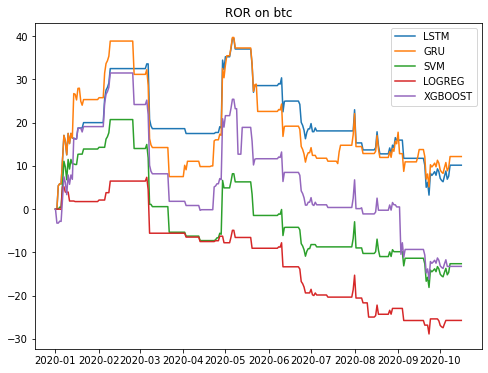

In [ ]:
visualize_ror(df_dict, 'btc')

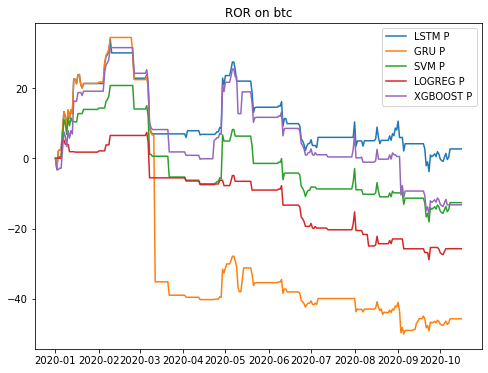

In [ ]:
visualize_ror(df_dict, 'btc',is_purged=True)

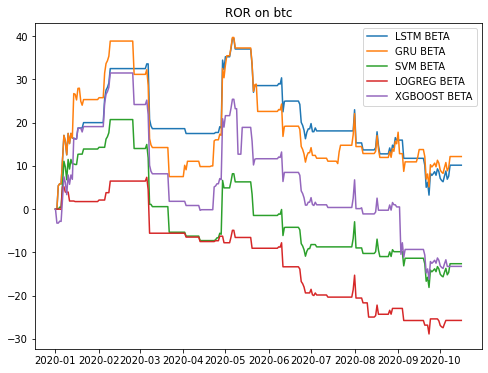

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True)

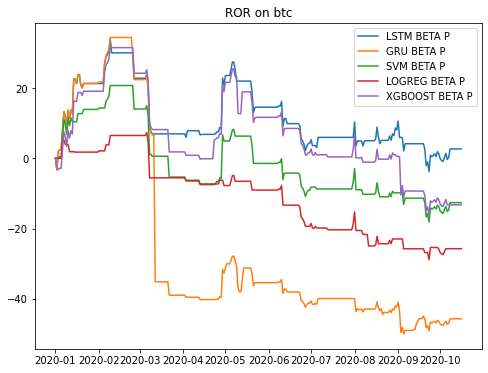

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True, is_purged = True)

## ETH

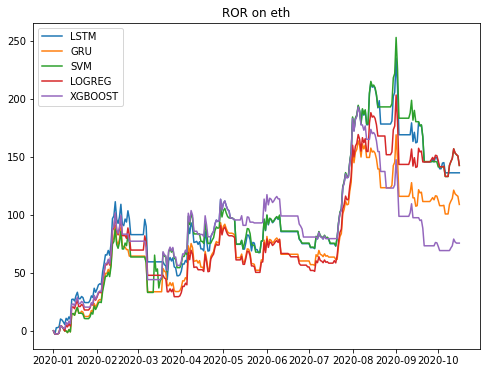

In [ ]:
visualize_ror(df_dict, 'eth')

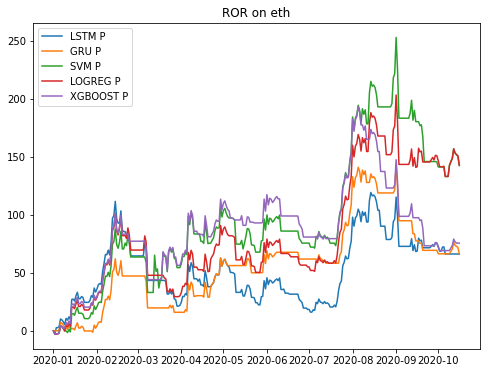

In [ ]:
visualize_ror(df_dict, 'eth',is_purged=True)

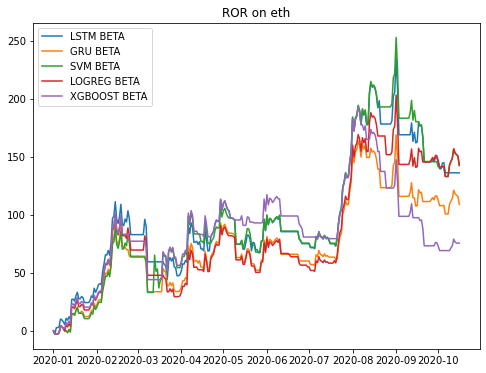

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True)

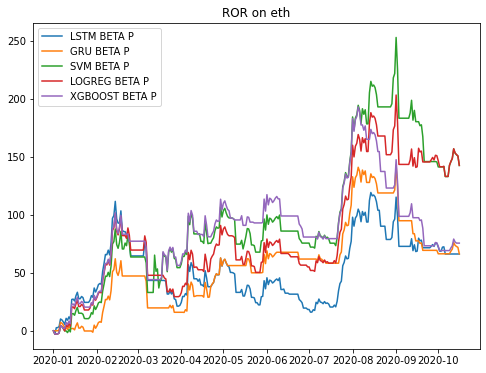

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True, is_purged = True)

## ADA

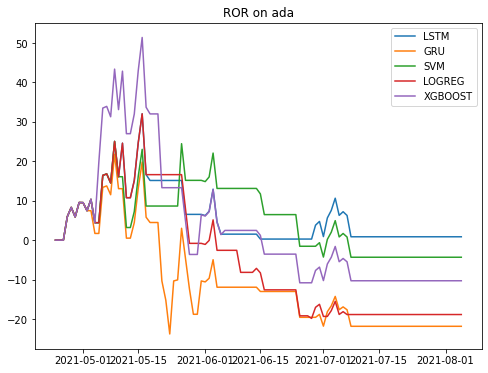

In [ ]:
visualize_ror(df_dict, 'ada')

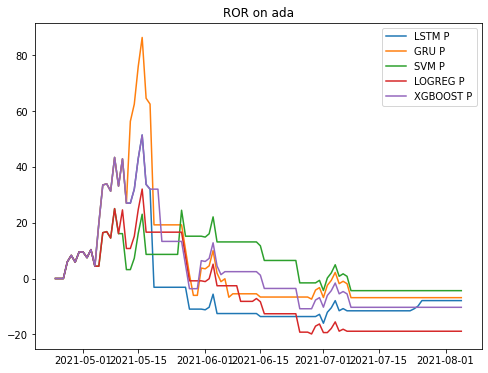

In [ ]:
visualize_ror(df_dict, 'ada',is_purged=True)

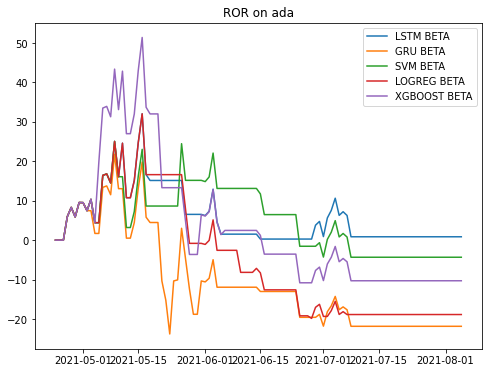

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True)

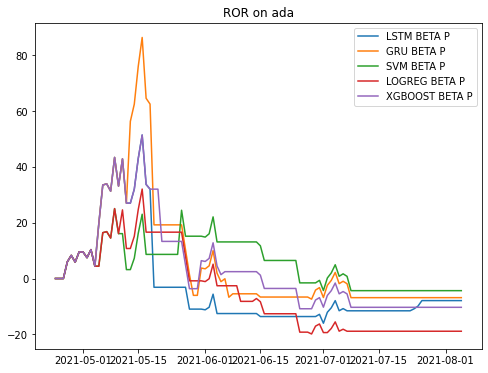

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True, is_purged = True)

## AAPL

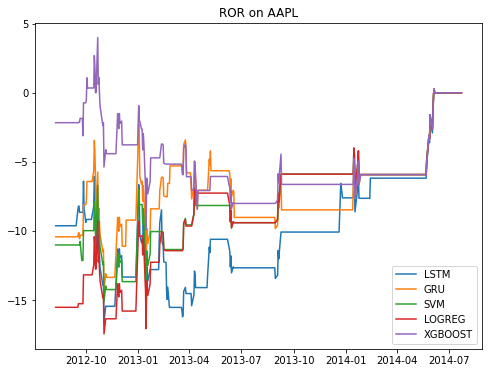

In [65]:
visualize_ror(df_dict, 'AAPL', df_type='sp')

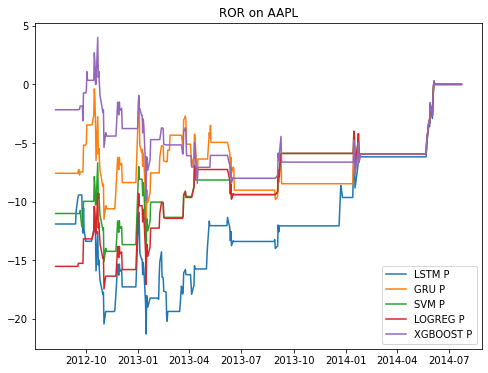

In [66]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_purged=True)

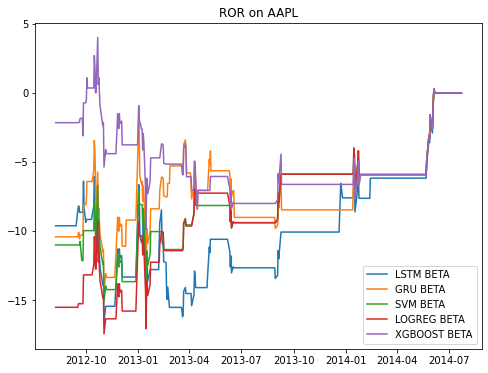

In [67]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True)

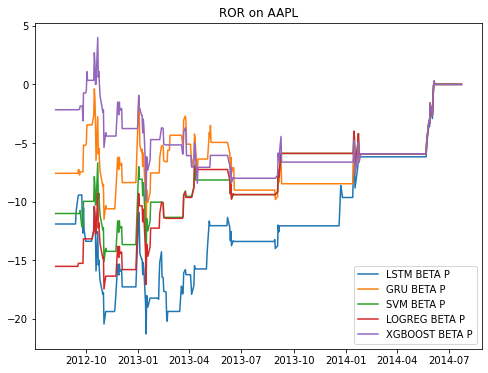

In [68]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True, is_purged = True)

## AMD

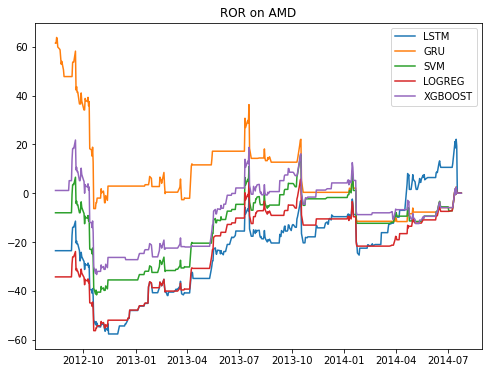

In [34]:
visualize_ror(df_dict, 'AMD', df_type='sp')

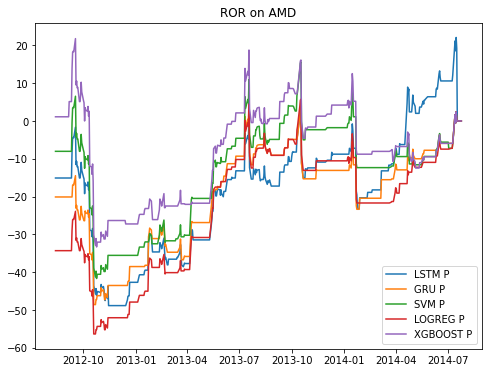

In [35]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_purged=True)

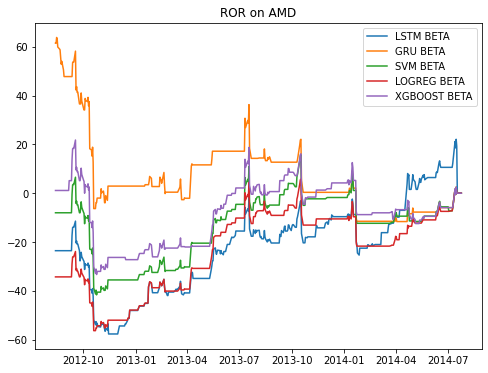

In [36]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True)

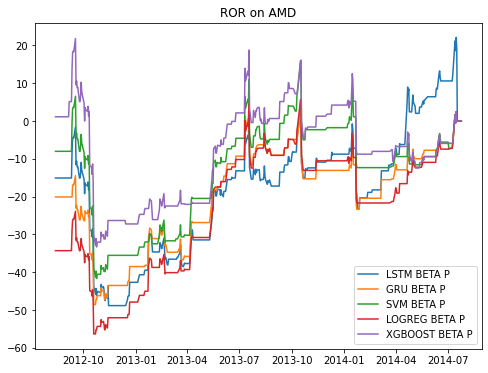

In [37]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True, is_purged = True)

## DVN

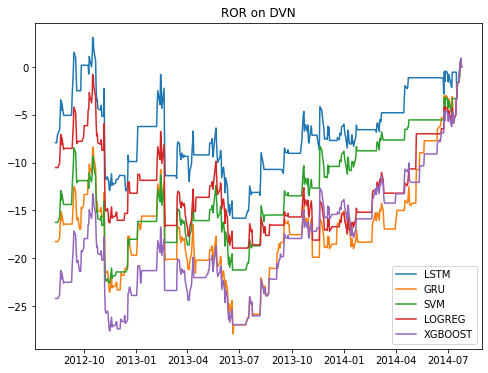

In [133]:
visualize_ror(df_dict, 'DVN', df_type='sp')

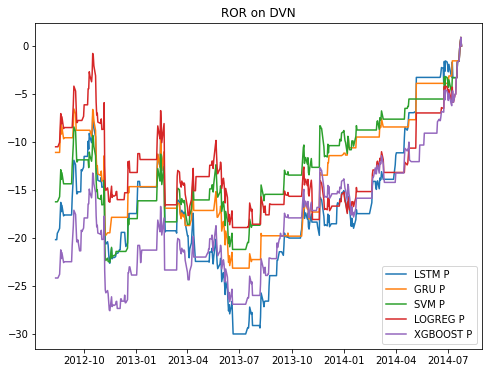

In [134]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_purged=True)

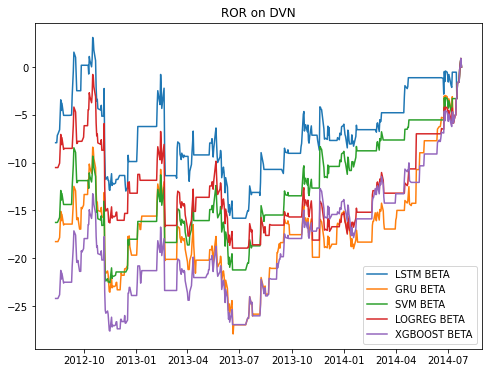

In [135]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_beta = True)

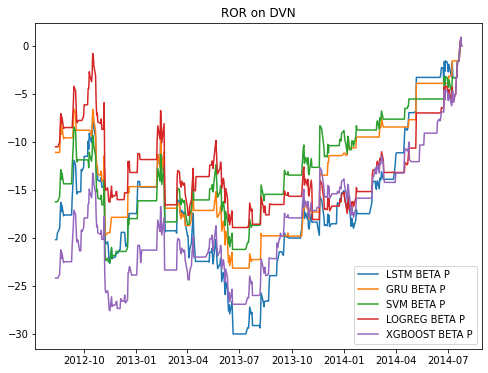

In [136]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_beta = True, is_purged = True)

## RMD

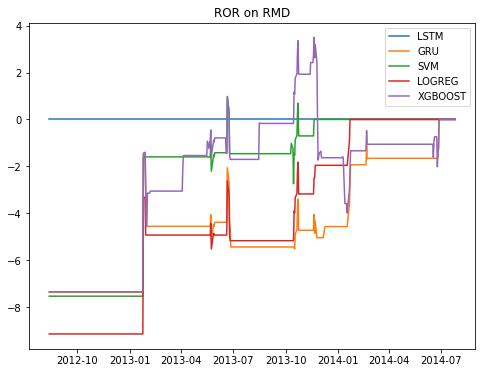

In [137]:
visualize_ror(df_dict, 'RMD', df_type='sp')

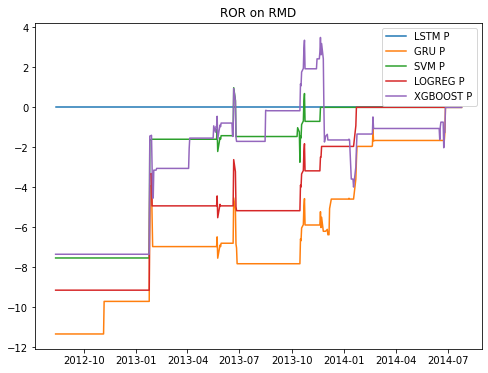

In [138]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_purged=True)

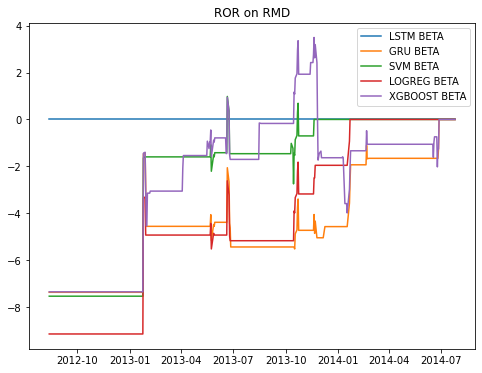

In [139]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_beta = True)

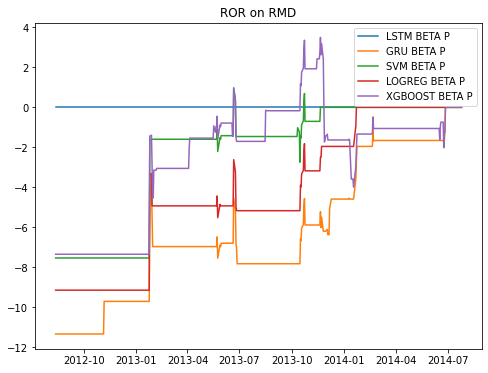

In [140]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_beta = True, is_purged = True)

## WU

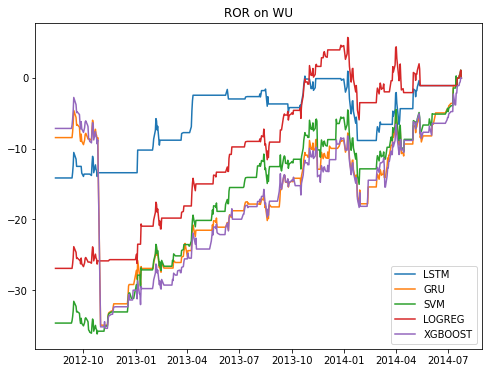

In [141]:
visualize_ror(df_dict, 'WU', df_type='sp')

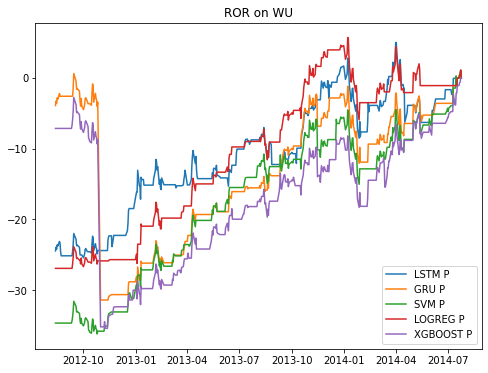

In [142]:
visualize_ror(df_dict, 'WU', df_type='sp', is_purged=True)

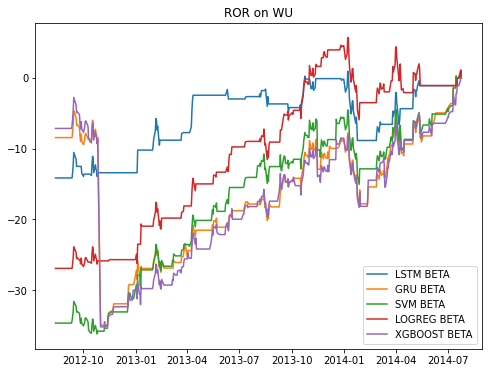

In [143]:
visualize_ror(df_dict, 'WU', df_type='sp', is_beta = True)

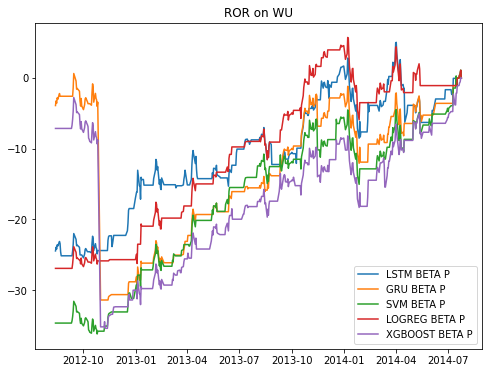

In [144]:
visualize_ror(df_dict, 'WU', df_type='sp', is_beta = True, is_purged = True)